In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/ph/wcdfy27570nc5m2_jjy6g9q00000gn/T/ipykernel_32078/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Contents
 1. Imports
 2. Introduction
 3. Intuition
 4. Study<br>
  4.1 Single Run<br>
  4.2 All Runs
 5. Conclusions

## Imports, etc. <a id="imports"></a>

In [2]:
from plotnine import *

import numpy as np
from scipy.stats import norm

In [3]:
import os
import pandas as pd
pd.set_option('display.max_rows',500)

import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

## Introduction <a name="introduction"></a>

We define a **cohort** as $n$ crops of the same recipe (or sometimes component) with the same planned harvest date. By default, the count of crops in a cohort $n$ is the same as the number of crops originally planned for the cohort $n_0$.  If however, at time of planting we have extra space that has not been committed to the harvest plan, we might **overseed** an additional $n'$ crops in the free space, giving us a cohort of size $$n = n_0 + n'$$

The object of the Overseed & Cull project is to increase overall yield, which we define as 

$$\begin{align}\frac{\sum^n salableCropMass}{\sum^{n_0} sqFtYears} &= \frac{n\cdot \overline{salableCropMass}}{\sum^{n_0} sqFtYears}\end{align}$$
for $n$ crops, where $\bar{x}$ is the average of $x$. Note that the denominator is only in terms of the harvest plan count $n_0$.

It stands to reason that we can improve this metric by somehow increasing $\overline{salableCropMass}$ without significantly changing $\sum sqFtYears$. As we're unable to go back in time and plant extra seeds to increase $n_0$, we can only remove crops. Because the $n'$ overseed crops are effectively free however, we can remove up to $n'$ without reducing expected yield below its default of 

$$ \frac{\sum^{n_0}salableCropMass}{\sum^{n_0}sqFtYears}$$

where both numerator and denominator are indexed in terms of the harvest plan count $n_0$.

If we can strategically remove crops in such a way that the distribution mean increases, our yield will increase. **Our objective then is to measure our ability to optimally select the crops for removal toward this goal**.

## Intuition  <a name="intuition"></a>

Imagine a game where we blindly draw ten samples from a Normal(0,1) distribution in hopes of getting the highest overall total. If we were to play 1000 times our results may look like this:

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 27'. Pick better value with 'binwidth'.


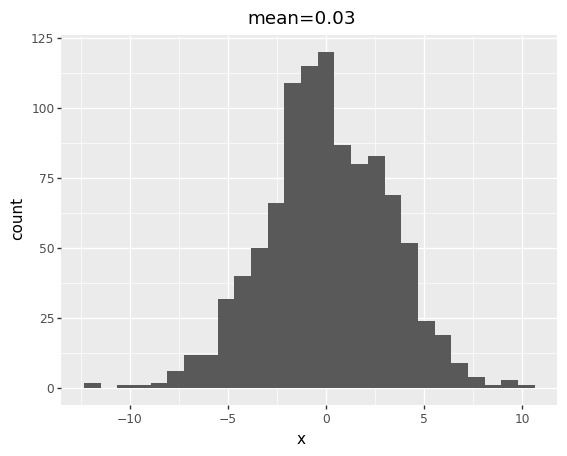

<ggplot: (359655735)>

In [4]:
samples = norm.rvs(size=10*1000).reshape(10,1000).sum(axis=0)

(
    ggplot(pd.DataFrame({'x':samples}), aes(x='x')) 
    + geom_histogram() 
    + ggtitle(f"mean={np.round(samples.mean(),2)}")
)

If, however, we could cheat and discard the lowest of each play's 10 values and draw again, then our distribution might shift:

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 26'. Pick better value with 'binwidth'.


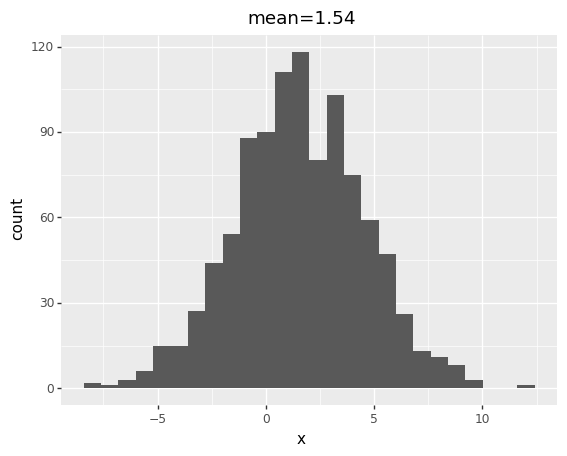

<ggplot: (361901674)>

In [5]:
draws = norm.rvs(size=10*1000).reshape(10,1000)
new_samples = draws.sum(axis=0) - draws.min(axis=0) + norm.rvs(size=1000)

ggplot(pd.DataFrame({'x':new_samples}), aes(x='x')) + geom_histogram() + ggtitle(f"mean={np.round(new_samples.mean(),2)}")

We can easily see that the crops we've removed, while not a random sample. have a different distribution than the Normal(0,1) from which they were drawn:

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 26'. Pick better value with 'binwidth'.
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 26'. Pick better value with 'binwidth'.


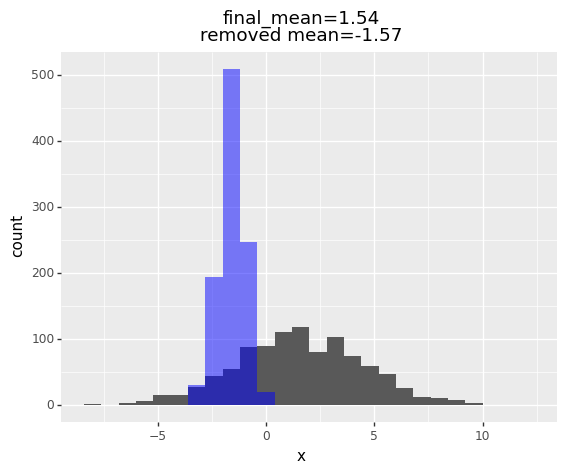

<ggplot: (361994346)>

In [6]:
(
    ggplot(pd.DataFrame({'x':draws.min(axis=0)}), aes(x='x')) 
    + geom_histogram(data=pd.DataFrame({'x':new_samples})) 
    + geom_histogram(fill='blue', alpha=0.5) 
    + ggtitle(f"final_mean={np.round(new_samples.mean(),2)}\nremoved mean={np.round(draws.min(axis=0).mean(),2)}")
)

Of course, we now are actually drawing 11 values per play and censoring the lowest value -- in computing the mean we're altering the numerator (choosing the best 10 of 11 values) and the denominator (dividing by 10 instead of 11).

At the same time if we discard draws at random and replace them with draws of the same distribution, then we can't expect our sum distribution to change:

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 25'. Pick better value with 'binwidth'.
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 23'. Pick better value with 'binwidth'.


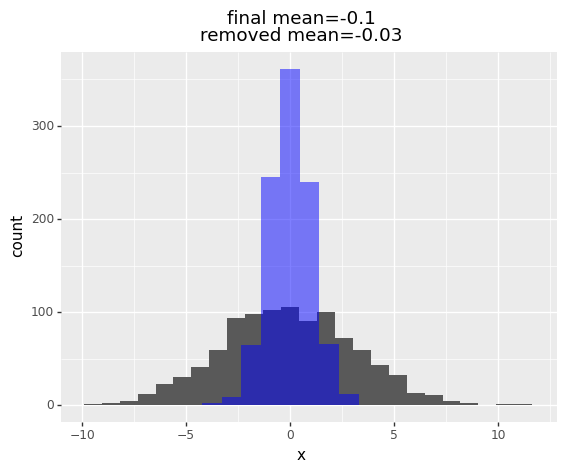

<ggplot: (362044377)>

In [7]:
first_draw = norm.rvs(size=10*1000).reshape(10,1000)
# remove the last column to replace with a new draw
re_draw = norm.rvs(size=1000)
samples_same = first_draw[:-1,:].sum(axis=0) + re_draw

(
    ggplot(pd.DataFrame({'x':samples_same}), aes(x='x')) 
    + geom_histogram() 
    + geom_histogram(data=pd.DataFrame({'x':re_draw}), fill='blue',alpha=0.5) 
    + ggtitle(f"final mean={np.round(samples_same.mean(),2)}\nremoved mean={np.round(first_draw[-1,:].mean(),2)}")
)

**Therefore, it falls to us to show that the distribution of crops we propose to remove is as different from the source distribution as possible.**

## Study  <a name="study"></a>

Let's start by finding the most common recipes in use, and let's focus on Farm 2 as our longest-running "normal" farm.

For each of these top 25 recipes we will investigate a hypothetical: Can we find a strategy to identify below-average crops before they're harvested?

### Approach <a name="approach"></a>

We gather historical data for the recipe-component pairs which have the most total crops. Data is grouped by (recipe / harvest date / crop age). 

* For each of 1000 iterations:
 * For each plant age in (1, recipe_length_days):
   * For each metric in (crop mass prediction, failure loss probability)
     0. Compute the average crop mass at harvest by crop for the cohort ("actual")
     1. Select the worst crop according to its metric ("cull"), its final crop mass at harvest ("ideal"), or at random ("random")
      1.a if by that date in the crop's life a termination has been requested, choose the next best
     2. Remove the selected crop
     3. Recompute the average crop mass at harvest among the crops that remain
     
If we do truly select the inferior crop, we expect the average to be higher than that obtained by removing a crop at random, and we also expect the average to be greater than the "actual" average.

In [8]:
qry = """
    select count(distinct crop_id) as n_crop_id, recipe_id, component_id, component_name
    from warehouse.dm_crops c
    join warehouse.dm_components p using (component_id)
    join warehouse.dm_recipe_stages r using (recipe_id)
    where farm_id = 2
    group by recipe_id, component_id, component_name
    order by n_crop_id desc
    limit 15
"""
frequent_recipes = pd.read_sql(qry,conn)
frequent_recipes

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


N_CROP_ID  RECIPE_ID  COMPONENT_ID COMPONENT_NAME
0        9452        641            14  Curly Iceberg
1        8216        447            14  Curly Iceberg
2        7900        642            12     Butterhead
3        6704        443             4      Baby Kale
4        6243        325            12     Butterhead
5        5808        445            12     Butterhead
6        5192        373             4      Baby Kale
7        4980        489             4      Baby Kale
8        4724        516            14  Curly Iceberg
9        4336        636            15          Basil
10       4028        472            22          Chard
11       3480        499            10  Green Romaine
12       3356        336            15          Basil
13       3344        391            14  Curly Iceberg
14       3028        493            14  Curly Iceberg

In [9]:
def gather_data_from_snowflake(component_id:int, recipe_id: int) -> pd.DataFrame:
    """
    
    """
    
    qry = f"""
    with crop_info as (
        select distinct c.seeded_on,
          crop_id,
          p.hour_starting_at, 
          p.hour_starting_at::date as prediction_date,
          datediff('day',c.seeded_on, prediction_date) as grow_day,
          row_number() over (partition by crop_id, prediction_date order by hour_starting_at) as max_daily_hour_starting_at,
          
          p.failure_probability,
          1-failure_probability as success_probability,
          
          p.q50_predicted_harvest_mass_lbs,

          c.outcome,
          nvl(c.salable_mass_lbs,0) as salable_mass_lbs,

          completed_on_planned,
          c.forecasted_yield_attributed_on,
          requested_termination_at,
          case when prediction_date >= requested_termination_at then 1 else 0 end as is_terminated_on_date,

          hash(forecasted_yield_attributed_on,component_id,recipe_id) as cohort_hash,
          dense_rank() over (order by cohort_hash) as cohort_id,

          dense_rank() over (partition by cohort_hash, grow_day order by salable_mass_lbs asc) as final_mass_rank

        from predict.m_crop_mass_preds p
        join warehouse.dm_crops c using (crop_id)

        where c.recipe_id = {recipe_id}
          and component_id = {component_id}
          and farm_id = 2
          and outcome in ('complete','terminated')

        and completed_at < dateadd('day',1,completed_on_planned)
        qualify 1 = max_daily_hour_starting_at
        order by hour_starting_at
    )
    select * 
    from crop_info
    """
    
    return pd.read_sql(qry,conn)

In [10]:
def statistics_from_subdf(sub_df: pd.DataFrame, 
                          cohort_id: int,
                          remove_n: int, 
                          grow_day: int, 
                          criterion='Q50_PREDICTED_HARVEST_MASS_LBS'):
    """
    According to either harvest mass predictions (Q50_PREDICTED_MASS_LBS) or
    crop failure probability (SUCCESS_PROBABILITY) compare the changes to average
    salable harvest mass by removing
    
     * the crop that appears worst on a given grow day (culled)
     * the crop which we know will have the worst harvest mass (ideal)
     * a crop selected at random (random)
    """
    
    # don't cull a crop if it's already dead
    smallest_idx = sub_df.query(f"IS_TERMINATED_ON_DATE==0")[criterion].values.argsort()[:remove_n]
    predicted_worst_n_crops = sub_df['CROP_ID'].iloc[smallest_idx]
    
    
    random_n_crops = sub_df['CROP_ID'].sample(len(sub_df))[0:remove_n]
    
    actual_average_mass = sub_df['SALABLE_MASS_LBS'].mean()
    
    culled_average_mass = sub_df.query('~CROP_ID.isin(@predicted_worst_n_crops)')['SALABLE_MASS_LBS'].mean()
    
    ideal_average_mass = sub_df.query(f'FINAL_MASS_RANK > {remove_n}')['SALABLE_MASS_LBS'].mean()
    
    random_average_mass = sub_df.query('~CROP_ID.isin(@random_n_crops)')['SALABLE_MASS_LBS'].mean()
    
    return pd.Series([
        actual_average_mass,
        culled_average_mass,
        ideal_average_mass,
        random_average_mass,
        grow_day,
        criterion,
        cohort_id],
    index=[
        'actual_average_mass',
        'culled_average_mass',
        'ideal_average_mass',
        'random_average_mass',
        'grow_day',
        'criterion',
        'cohort_id'])

In [11]:
def generate_results(component_id:int, recipe_id:int, n_to_cull:int, n_samples=1000):
    df = gather_data_from_snowflake(component_id, recipe_id)
    print(df.shape)
    
    n_cohort = df['COHORT_ID'].nunique()
    
    assert df['COHORT_ID'].max() == n_cohort
    
    criteria = ['Q50_PREDICTED_HARVEST_MASS_LBS','SUCCESS_PROBABILITY']
    
    grow_days = df['GROW_DAY'].unique()
    
    # prepare empty list
    statistics = [None]*n_samples*len(grow_days)*len(criteria)

    idx = 0

    for criterion in criteria:
        for grow_day in grow_days:
            for i in range(n_samples):        

                # Select a random cohort
                cohort_id = np.random.randint(n_cohort)

                sub_df = (
                    df
                    .query(f"COHORT_ID=={cohort_id}")
                    .query(f"GROW_DAY=={grow_day}")
                    .set_index('CROP_ID',drop=False)
                )

                results = statistics_from_subdf(sub_df,cohort_id, n_to_cull,grow_day,criterion)

                statistics[idx] = results

                idx += 1    
    result_df = pd.concat(statistics, axis=1).T
    
    return df, result_df

In [12]:
def graphs(in_df, recipe_id):
    g = (
        in_df

        .assign(
            #ideal_minus_culled      = lambda x: x['ideal_final_mass'] - x['culled_final_mass'],
                culled_avg_minus_actual = lambda x: x['culled_average_mass'] - x['actual_average_mass'],
                ideal_avg_minus_actual  = lambda x: x['ideal_average_mass'] - x['actual_average_mass'],
                random_avg_minus_actual = lambda x: x['random_average_mass'] - x['actual_average_mass'],
                grow_day_cat            = lambda x: pd.Categorical(x['grow_day'])
               )

        [['grow_day_cat','criterion','random_avg_minus_actual','culled_avg_minus_actual','ideal_avg_minus_actual']]
        
        .rename(columns={'random_avg_minus_actual':'Random vs Actual', 
                         'culled_avg_minus_actual':'Culled vs Actual', 
                         'ideal_avg_minus_actual':'Ideal vs Actual'})

        .pipe(lambda d: pd.melt(d,id_vars=['criterion','grow_day_cat']))

        .dropna()
        .assign(value = lambda x: x['value'].astype(float))

        .pipe(lambda d: ggplot(d, aes(x='grow_day_cat',y='value',fill='variable')) 
              + geom_hline(yintercept=0,color='red')
              + geom_boxplot() 
              + facet_wrap('criterion',nrow=2)

              + theme(figure_size=(18,12)) 
              + ylim(-5,5)
              + labs(y="$\Delta Mean Crop Mass per Cohort (lbs) - Higher is Better", x="Crop Age (Days)",fill="Measure")
              + ggtitle(f"Recipe {recipe_id}\nChange in Mass of Average Crop in Cohort\nIdeal vs Informed by Crop Mass vs Random")
             )
    )    
    
    return g

### Single run  <a name="singlerun"></a>

In [13]:
df = gather_data_from_snowflake(14,641)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [14]:
d, rd = generate_results(14,641,n_to_cull=1)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(101690, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 8500 rows containing non-finite values.


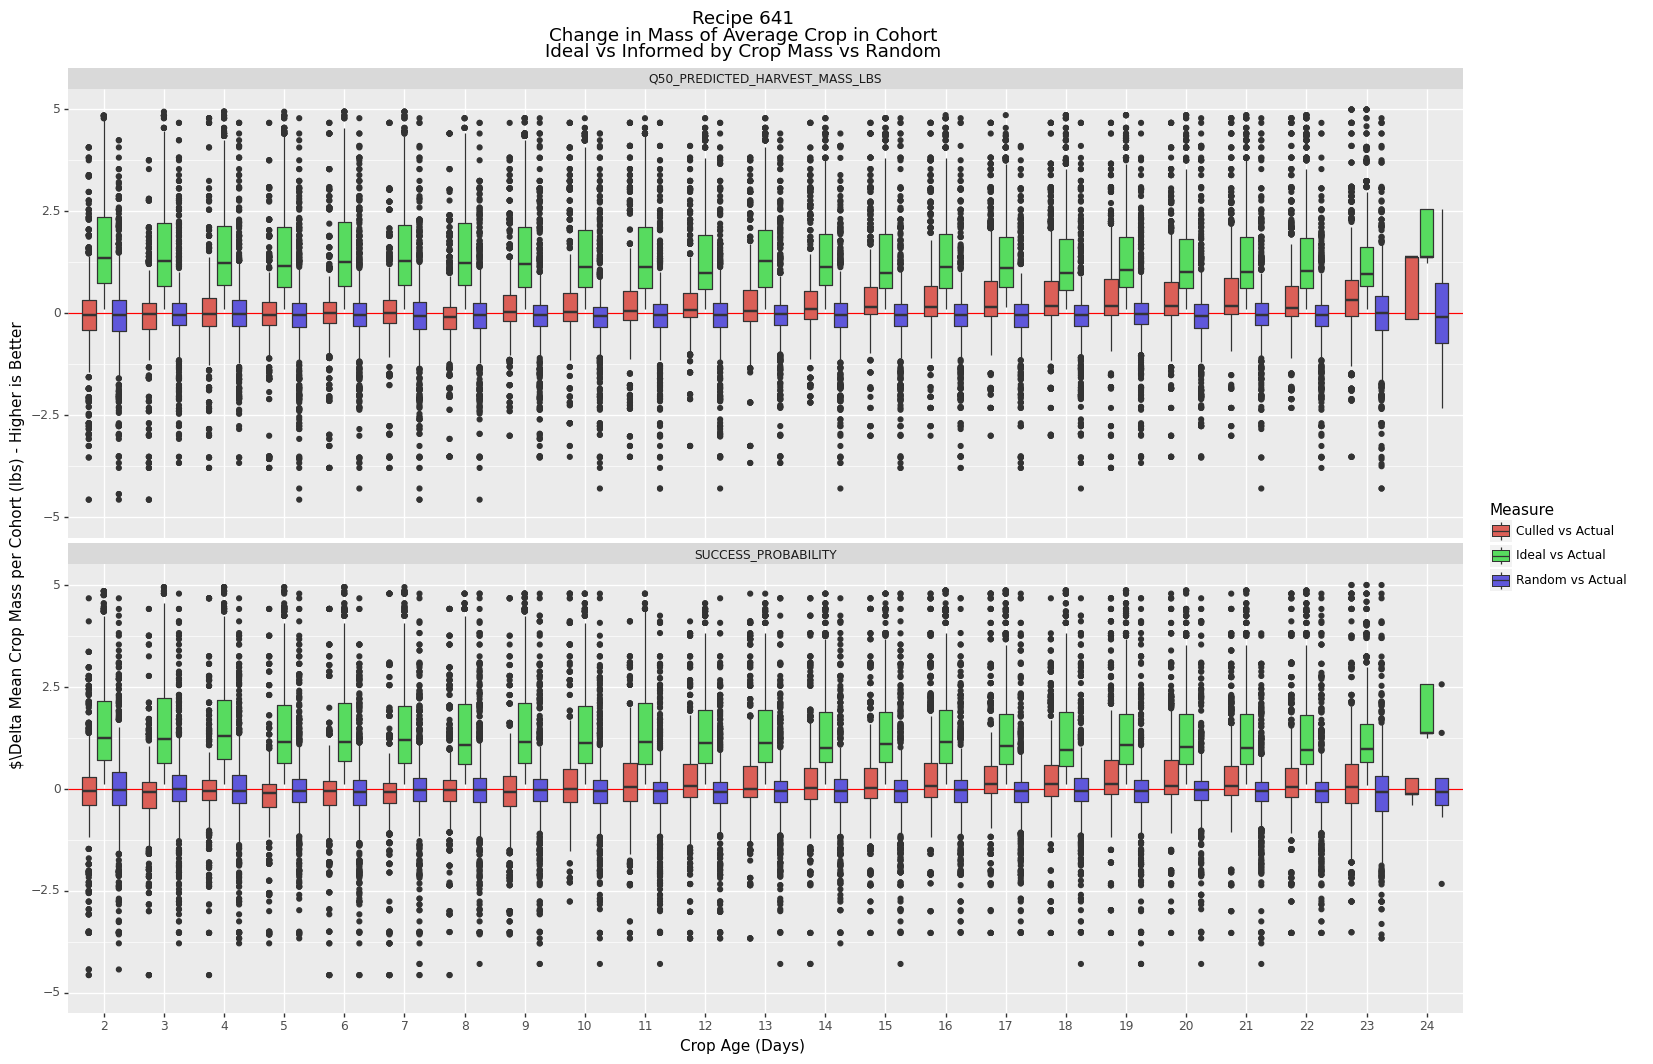

<ggplot: (362166001)>

In [15]:
graphs(rd,641)

In [16]:
d.query('COHORT_ID==48').sort_values(['GROW_DAY','CROP_ID'])

SEEDED_ON  CROP_ID    HOUR_STARTING_AT PREDICTION_DATE  GROW_DAY  \
50079  2022-07-28   237884 2022-07-30 16:00:00      2022-07-30         2   
50154  2022-07-28   237886 2022-07-30 16:00:00      2022-07-30         2   
50119  2022-07-28   237924 2022-07-30 16:00:00      2022-07-30         2   
50263  2022-07-28   237884 2022-07-31 16:00:00      2022-07-31         3   
50495  2022-07-28   237886 2022-07-31 16:00:00      2022-07-31         3   
50344  2022-07-28   237924 2022-07-31 16:00:00      2022-07-31         3   
50739  2022-07-28   237884 2022-08-01 16:00:00      2022-08-01         4   
50611  2022-07-28   237886 2022-08-01 16:00:00      2022-08-01         4   
50727  2022-07-28   237924 2022-08-01 16:00:00      2022-08-01         4   
50946  2022-07-28   237884 2022-08-02 16:00:00      2022-08-02         5   
51014  2022-07-28   237886 2022-08-02 16:00:00      2022-08-02         5   
51069  2022-07-28   237924 2022-08-02 16:00:00      2022-08-02         5   
51247  2022-07-28   237884 2022-08-03 16:00:00      2022-08-03         6   
51286  2022-07-28   237886 2022-08-03 16:00:00      2022-08-03         6   
51354  2022-07-28   237924 2022-08-03 16:00:00      2022-08-03         6   
51522  2022-07-28   237884 2022-08-04 16:00:00      2022-08-04         7   
51501  2022-07-28   237886 2022-08-04 16:00:00      2022-08-04         7   
51510  2022-07-28   237924 2022-08-04 16:00:00      2022-08-04         7   
51763  2022-07-28   237884 2022-08-05 16:00:00      2022-08-05         8   
51919  2022-07-28   237886 2022-08-05 16:00:00      2022-08-05         8   
52119  2022-07-28   237884 2022-08-06 16:00:00      2022-08-06         9   
52101  2022-07-28   237886 2022-08-06 16:00:00      2022-08-06         9   
51954  2022-07-28   237924 2022-08-06 16:00:00      2022-08-06         9   
52456  2022-07-28   237884 2022-08-07 16:00:00      2022-08-07        10   
52262  2022-07-28   237886 2022-08-07 16:00:00      2022-08-07        10   
52519  2022-07-28   237924 2022-08-07 16:00:00      2022-08-07        10   
52802  2022-07-28   237884 2022-08-08 16:00:00      2022-08-08        11   
52709  2022-07-28   237886 2022-08-08 16:00:00      2022-08-08        11   
52921  2022-07-28   237924 2022-08-08 16:00:00      2022-08-08        11   
53292  2022-07-28   237884 2022-08-09 16:00:00      2022-08-09        12   
53166  2022-07-28   237886 2022-08-09 16:00:00      2022-08-09        12   
53265  2022-07-28   237924 2022-08-09 16:00:00      2022-08-09        12   
53584  2022-07-28   237884 2022-08-10 16:00:00      2022-08-10        13   
53381  2022-07-28   237886 2022-08-10 16:00:00      2022-08-10        13   
53529  2022-07-28   237924 2022-08-10 16:00:00      2022-08-10        13   
53994  2022-07-28   237884 2022-08-11 16:00:00      2022-08-11        14   
53797  2022-07-28   237886 2022-08-11 16:00:00      2022-08-11        14   
53711  2022-07-28   237924 2022-08-11 16:00:00      2022-08-11        14   
54400  2022-07-28   237884 2022-08-12 16:00:00      2022-08-12        15   
54244  2022-07-28   237886 2022-08-12 16:00:00      2022-08-12        15   
54461  2022-07-28   237884 2022-08-13 16:00:00      2022-08-13        16   
54711  2022-07-28   237886 2022-08-13 16:00:00      2022-08-13        16   

       MAX_DAILY_HOUR_STARTING_AT  FAILURE_PROBABILITY  SUCCESS_PROBABILITY  \
50079                           1             0.061548             0.938452   
50154                           1             0.061548             0.938452   
50119                           1             0.053866             0.946134   
50263                           1             0.065917             0.934083   
50495                           1             0.065917             0.934083   
50344                           1             0.051855             0.948145   
50739                           1             0.079496             0.920504   
50611                           1             0.079496             0.920504   
50727                       

In [17]:
rd.head(n=10)

actual_average_mass culled_average_mass ideal_average_mass  \
0           27.747741           27.482038          28.814962   
1             24.9315              23.902              29.34   
2              22.371             21.7925           23.28175   
3              11.863              23.726             23.726   
4              31.755                 NaN                NaN   
5             27.2155           27.278667             29.002   
6              34.902           36.816667          36.816667   
7           25.461714           24.308833          29.705333   
8              31.784              31.902            34.9624   
9           25.793083           25.758455          26.741636   

  random_average_mass grow_day                       criterion cohort_id  
0           27.724615        2  Q50_PREDICTED_HARVEST_MASS_LBS       127  
1              23.902        2  Q50_PREDICTED_HARVEST_MASS_LBS        32  
2             21.7925        2  Q50_PREDICTED_HARVEST_MASS_LBS       158  
3              23.726        2  Q50_PREDICTED_HARVEST_MASS_LBS       128  
4                 NaN        2  Q50_PREDICTED_HARVEST_MASS_LBS        58  
5           27.278667        2  Q50_PREDICTED_HARVEST_MASS_LBS       249  
6              35.758        2  Q50_PREDICTED_HARVEST_MASS_LBS       101  
7           24.895333        2  Q50_PREDICTED_HARVEST_MASS_LBS       106  
8             34.9624        2  Q50_PREDICTED_HARVEST_MASS_LBS       195  
9           25.758455        2  Q50_PREDICTED_HARVEST_MASS_LBS       260

In [18]:
rd.query('cohort_id==222')

actual_average_mass culled_average_mass ideal_average_mass  \
392                 33.73                 NaN                NaN   
432                 33.73                 NaN                NaN   
489                 33.73                 NaN                NaN   
1724            29.290667           28.887091          31.953455   
1810            29.290667           28.887091          31.953455   
2107            29.290667           28.887091          31.953455   
2158            29.290667           28.887091          31.953455   
2428            29.290667           28.887091          31.953455   
3166            29.290667           29.678727          31.953455   
3299            29.290667           29.678727          31.953455   
3331            29.290667           29.678727          31.953455   
3375            29.290667           29.678727          31.953455   
3467            29.290667           29.678727          31.953455   
3591            29.290667           29.678727          31.953455   
3618            29.290667           29.678727          31.953455   
4172            29.290667           28.731364          31.953455   
4744            29.290667           28.731364          31.953455   
4795            29.290667           28.731364          31.953455   
5404            29.290667           29.678727          31.953455   
5793            29.290667           29.678727          31.953455   
5863            29.290667           29.678727          31.953455   
6105            29.290667           28.731364          31.953455   
6501            29.290667           28.731364          31.953455   
6679            29.290667           28.731364          31.953455   
6700            29.290667           28.731364          31.953455   
6881            29.290667           28.731364          31.953455   
7274            29.290667           29.848455          31.953455   
7733            29.290667           29.848455          31.953455   
7756            29.290667           29.848455          31.953455   
8616            29.290667           29.848455          31.953455   
8700            29.290667           29.848455          31.953455   
8760            29.290667           29.848455          31.953455   
9048            29.290667           31.953455          31.953455   
9280            29.290667           31.953455          31.953455   
9493            29.290667           31.953455          31.953455   
9951            29.290667           31.953455          31.953455   
9965            29.290667           31.953455          31.953455   
9984            29.290667           31.953455          31.953455   
10320           29.290667           31.953455          31.953455   
10716           29.290667           31.953455          31.953455   
10945           29.290667           31.953455          31.953455   
11060           29.290667           31.953455          31.953455   
11649           29.290667           31.953455          31.953455   
11799           29.290667           31.953455          31.953455   
12058           29.290667           31.953455          31.953455   
12126           29.290667           31.953455          31.953455   
12133           29.290667           31.953455          31.953455   
12496           29.290667           31.953455          31.953455   
12959           29.290667           31.953455          31.953455   
12971           29.290667           31.953455          31.953455   
14017           31.953455             32.8333            32.8554   
14449           31.953455             32.8333            32.8554   
14617           31.953455             32.8333            32.8554   
14630           31.953455             32.8333            32.8554   
14919           31.953455             32.8333            32.8554   
15065           31.953455             32.8554            32.8554   
15103           31.953455             32.8554            32.8554   
15183           31.953455             32.8554            32.85

### All Runs  <a name="allruns"></a>

In [19]:
recipe_dfs = {}

for _, r in frequent_recipes.iterrows():
    
    _, recipe_dfs[r.RECIPE_ID] = generate_results(r.COMPONENT_ID,r.RECIPE_ID,n_to_cull=1)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(101690, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(97049, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(113634, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(62788, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(31274, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(83022, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(12515, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(54660, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(32150, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(87003, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(30437, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(58483, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(15928, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(1493, 18)


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


(34485, 18)


*Ed. No data returned for this last query*

Recipe: 641


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 8425 rows containing non-finite values.


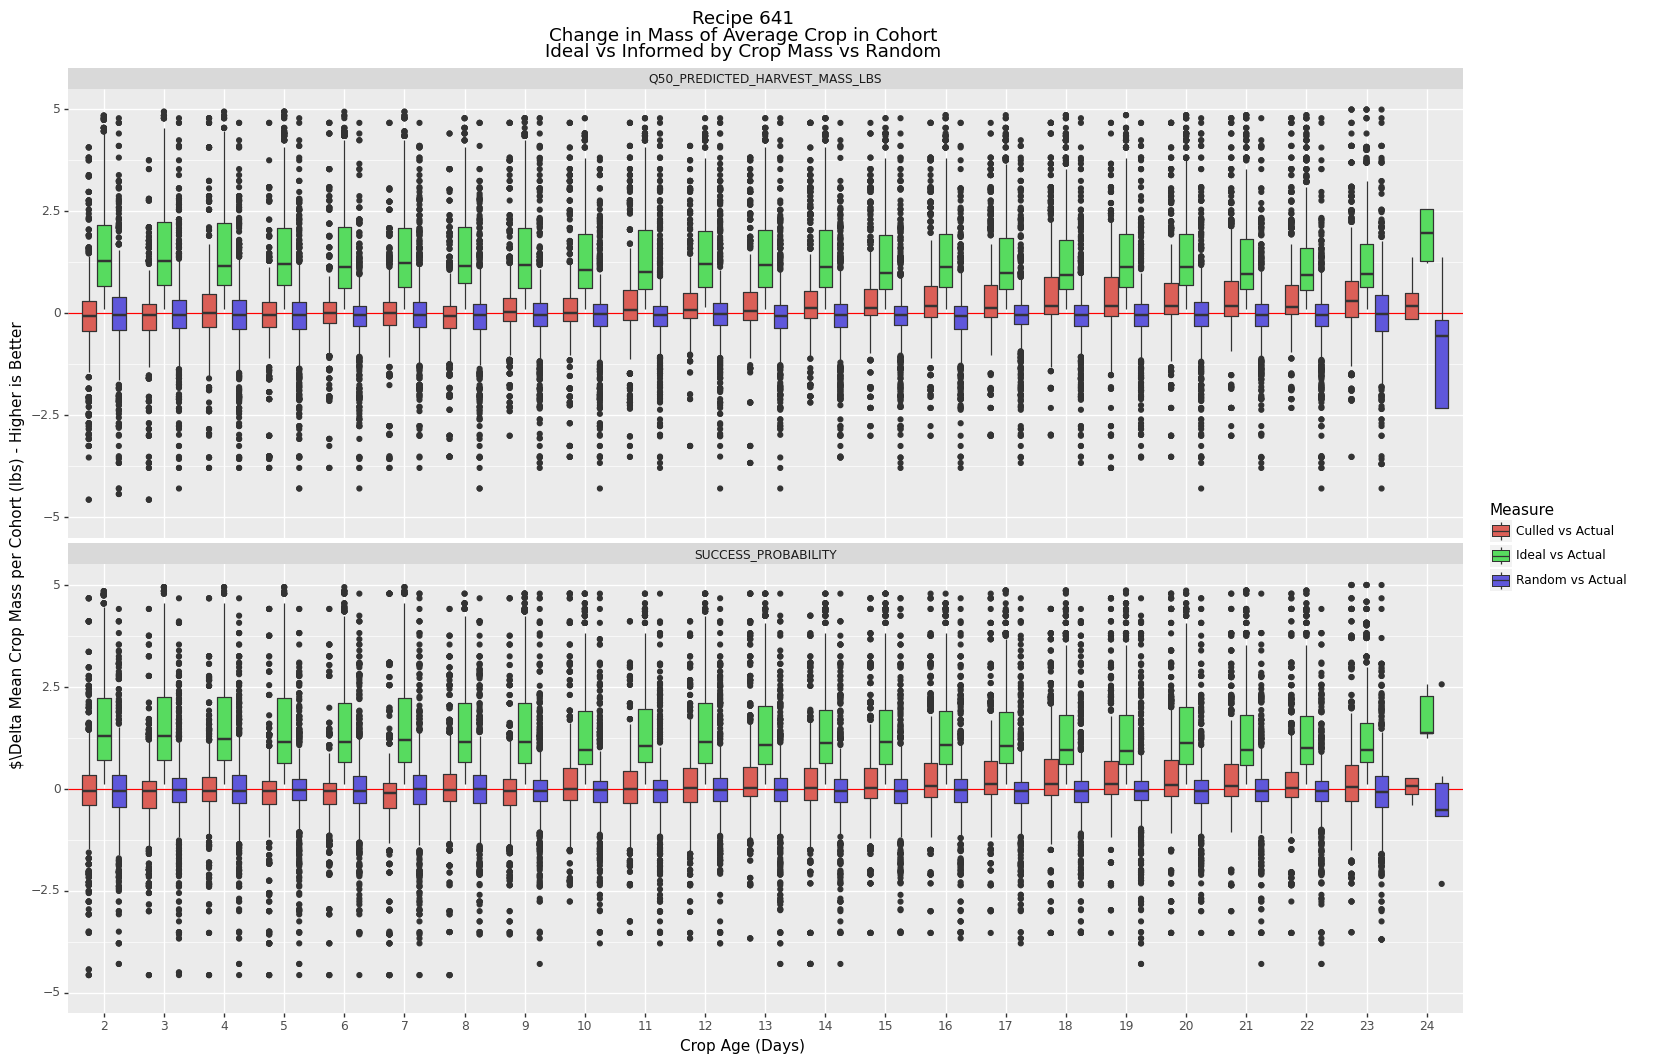


Recipe: 447


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 14959 rows containing non-finite values.


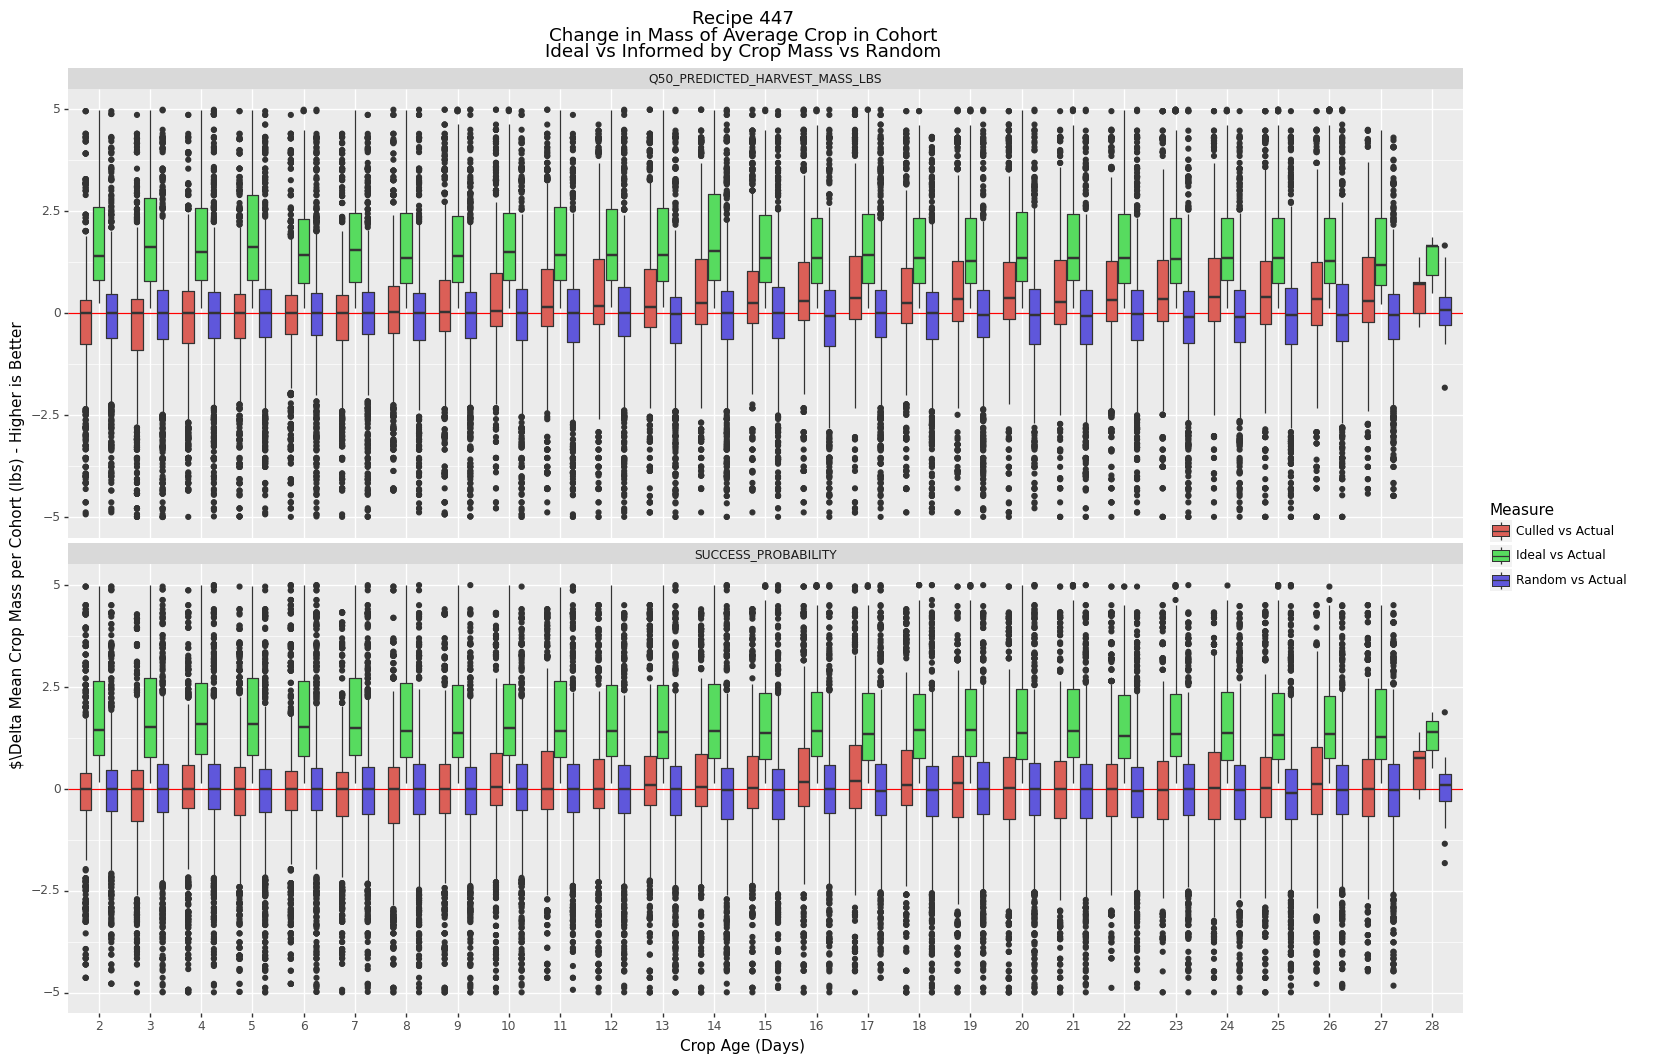


Recipe: 642


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 17763 rows containing non-finite values.


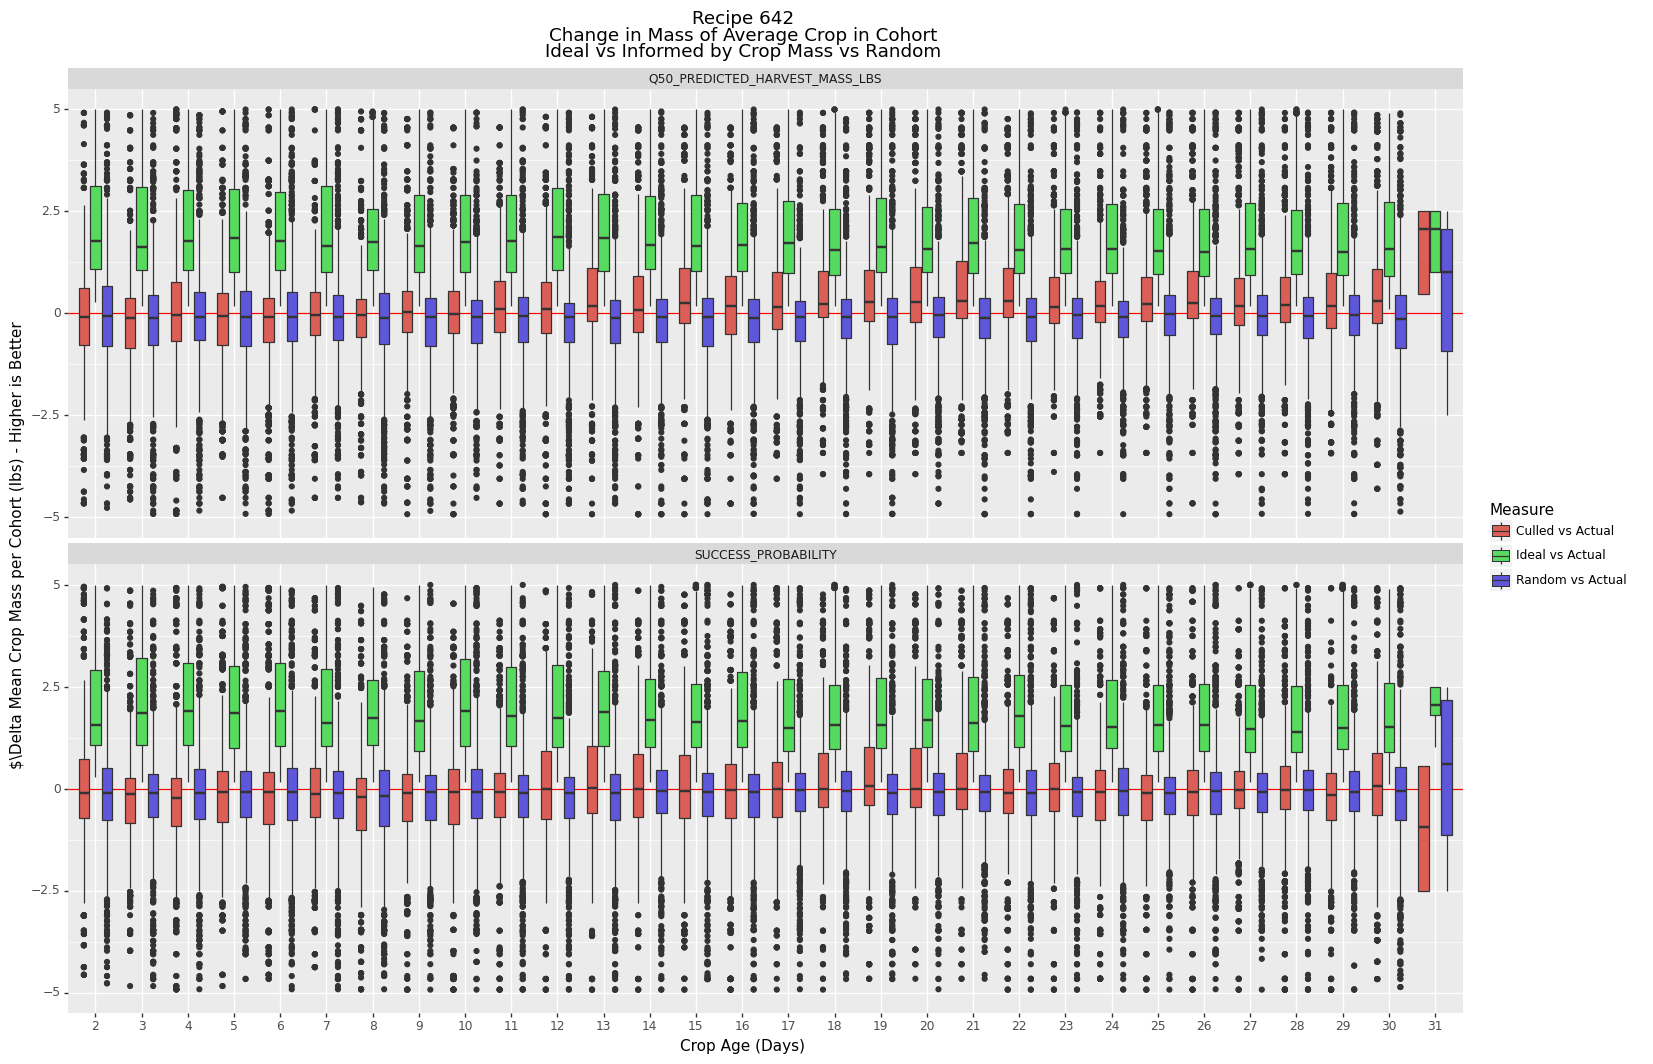


Recipe: 443


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 460 rows containing non-finite values.


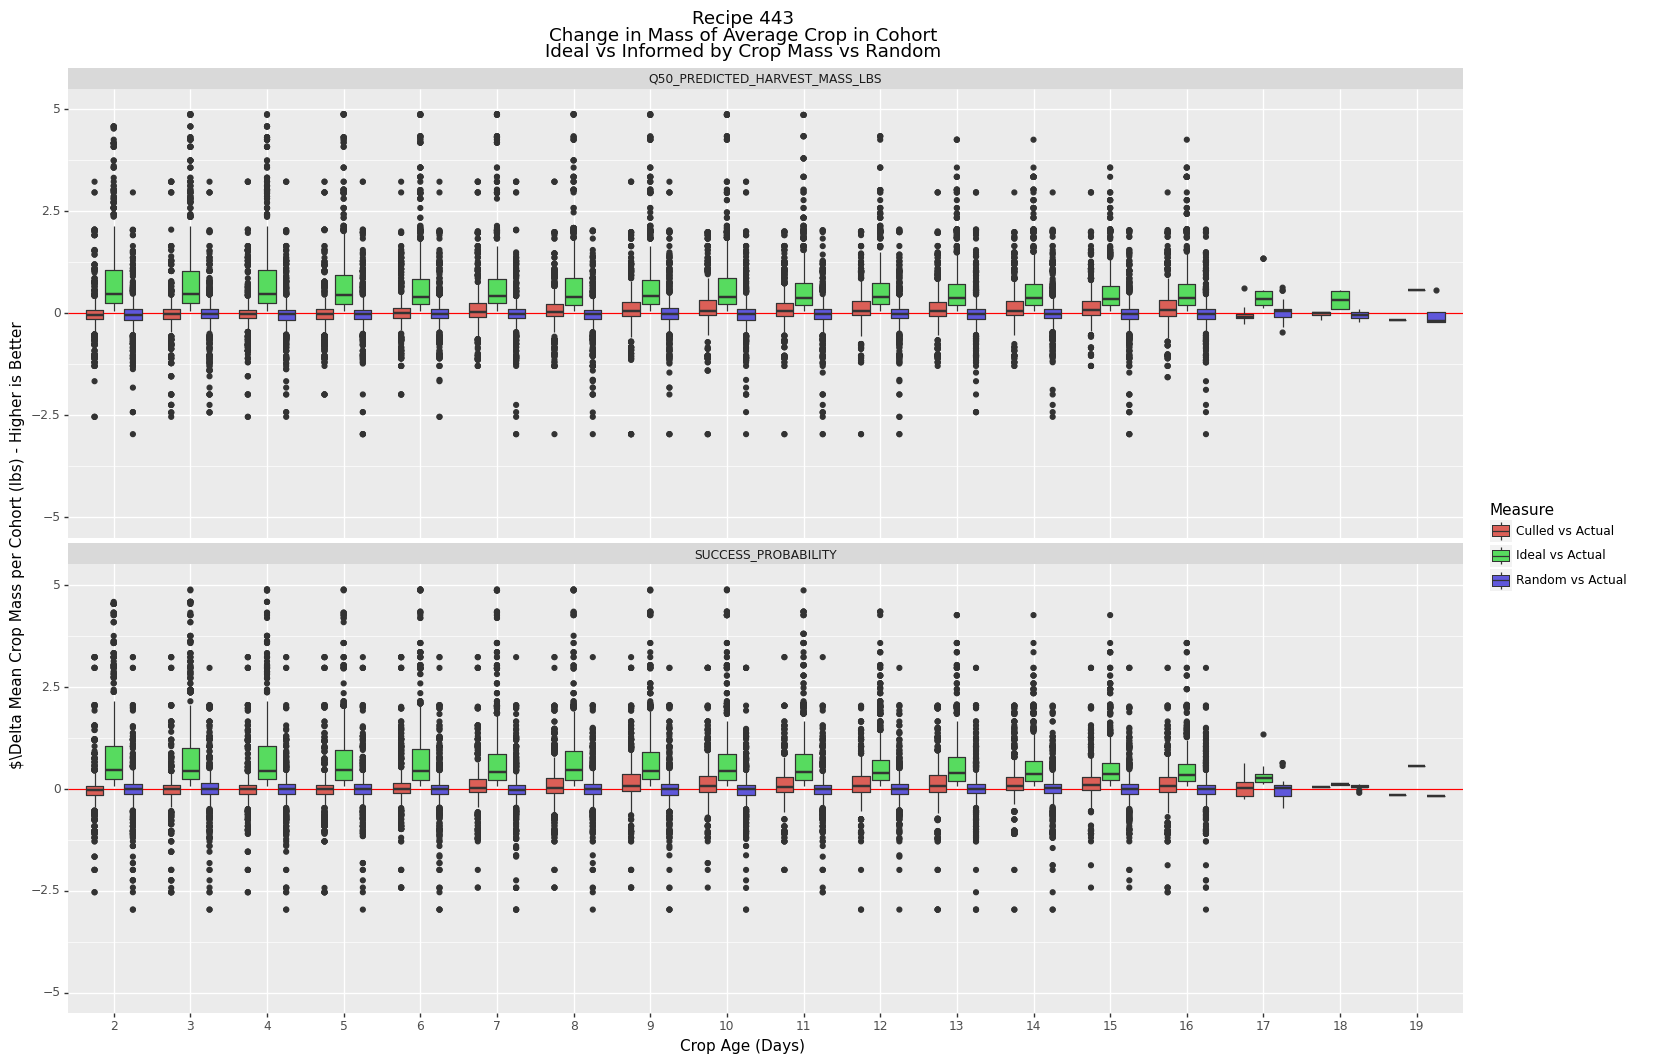


Recipe: 325


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 8397 rows containing non-finite values.


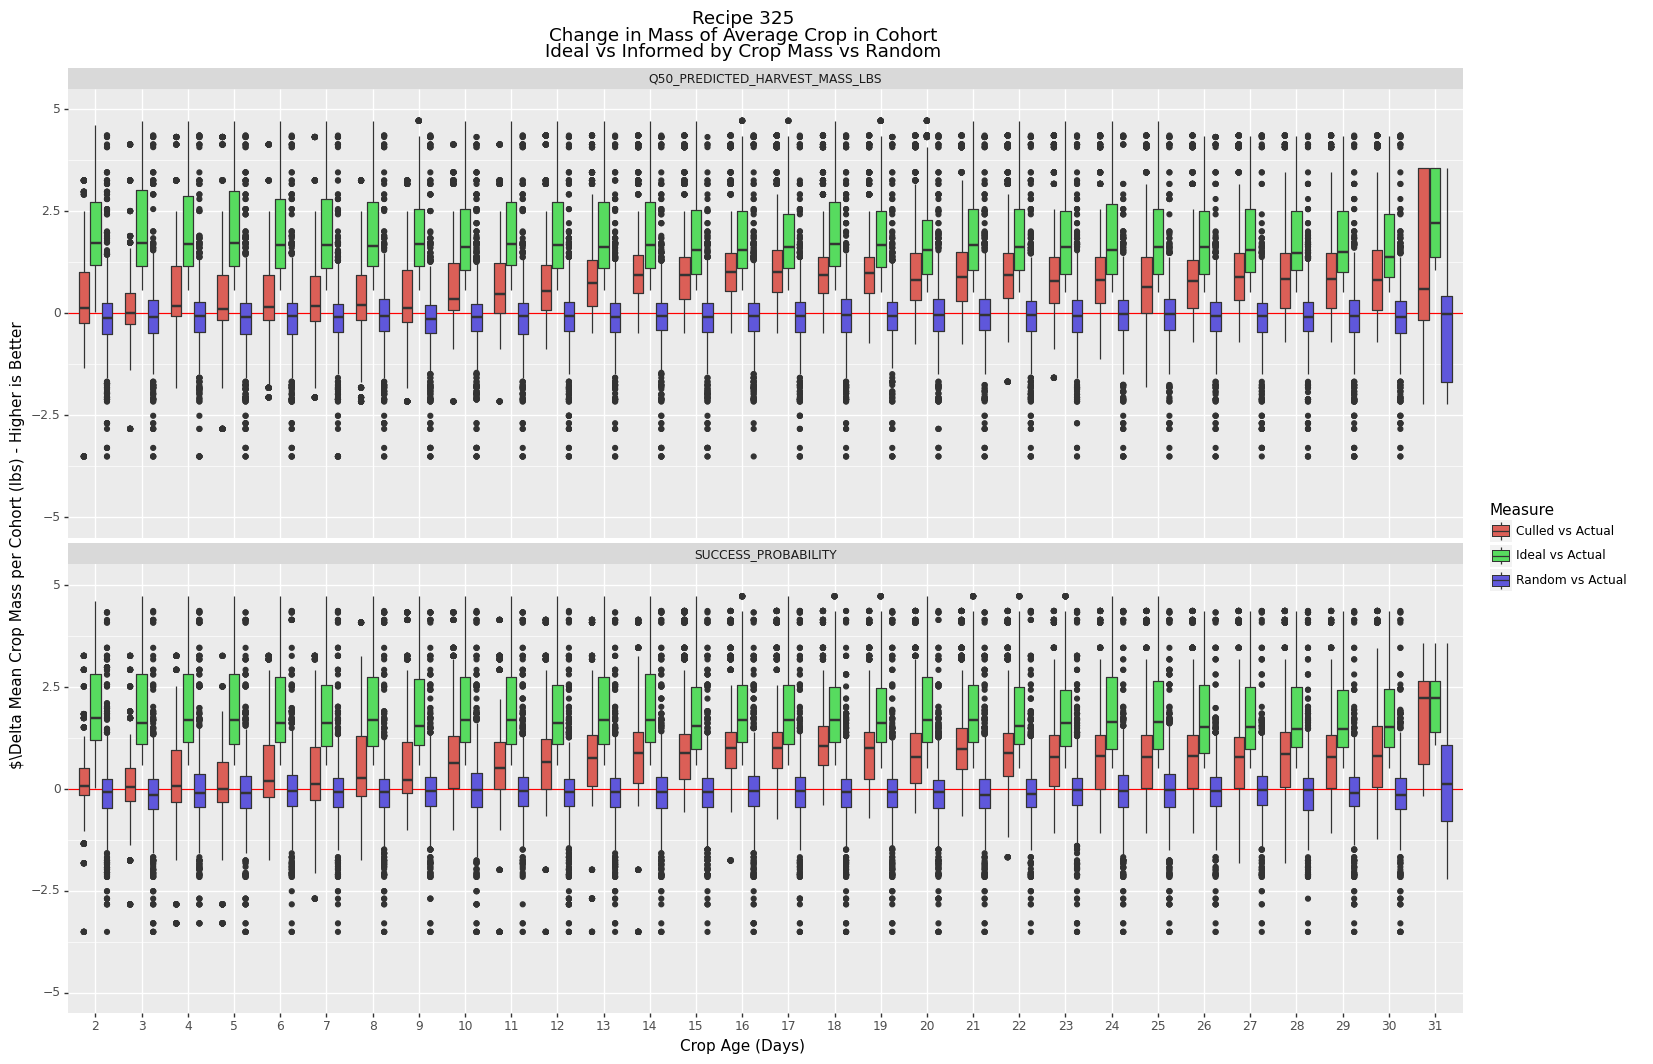


Recipe: 445


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 22686 rows containing non-finite values.


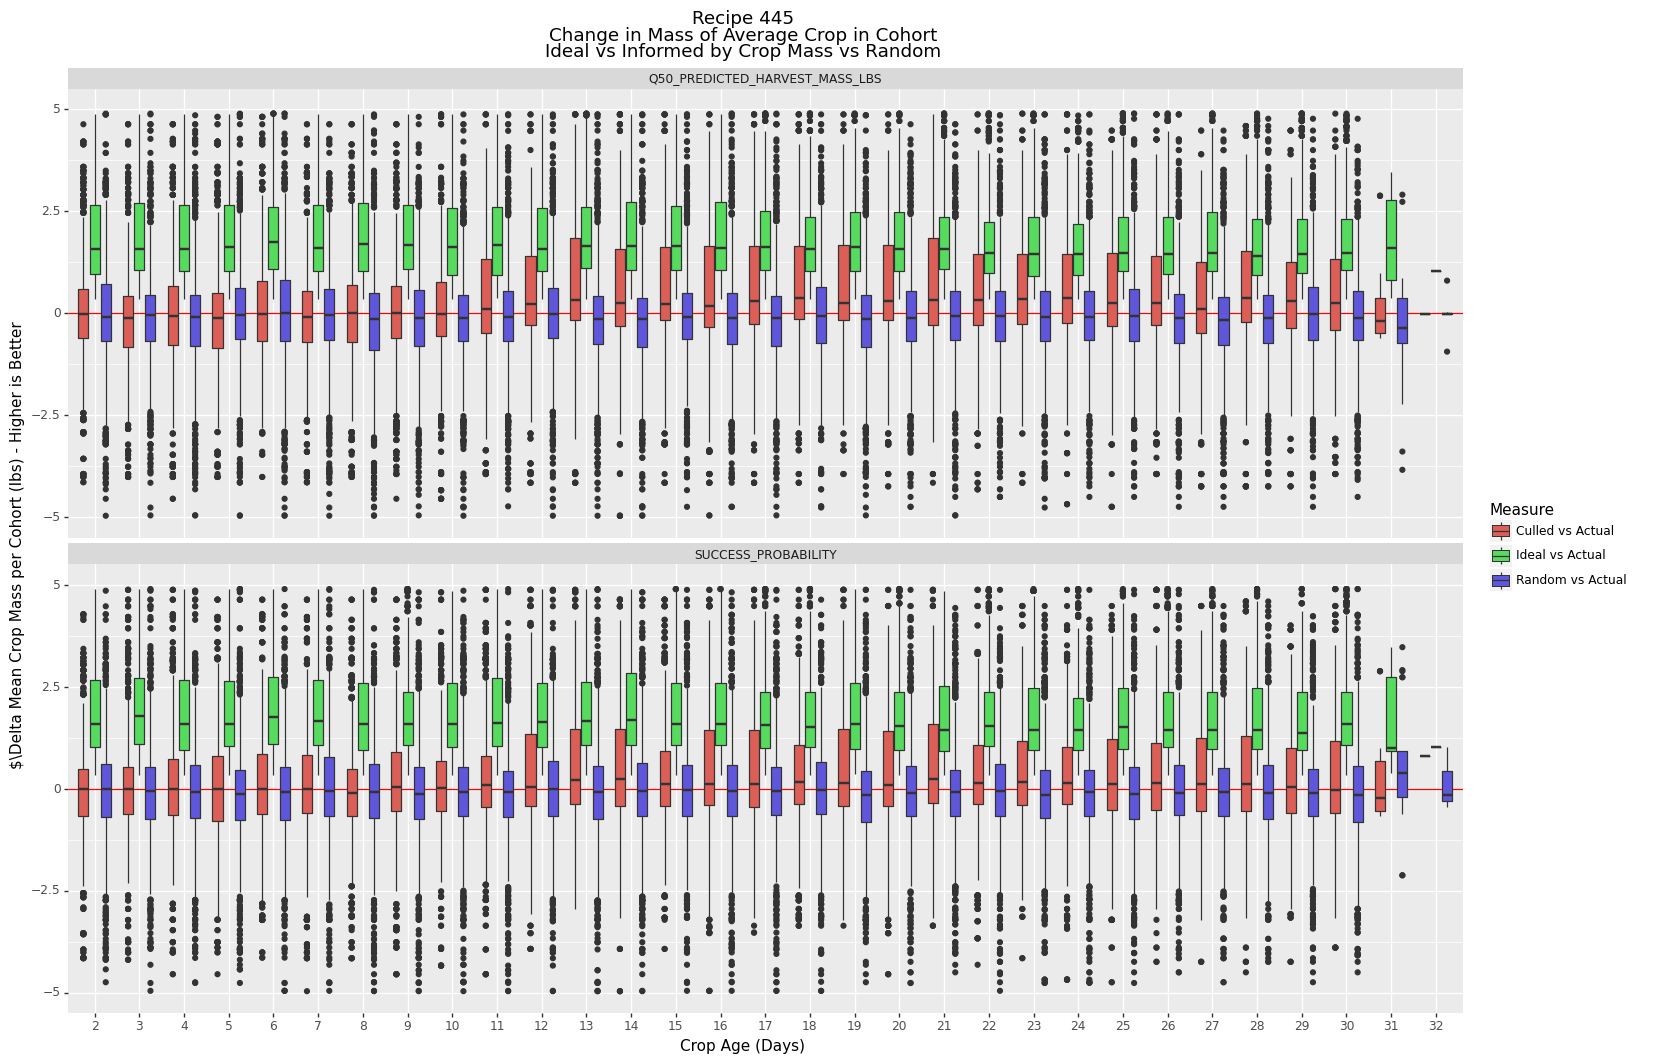


Recipe: 373


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 500 rows containing non-finite values.


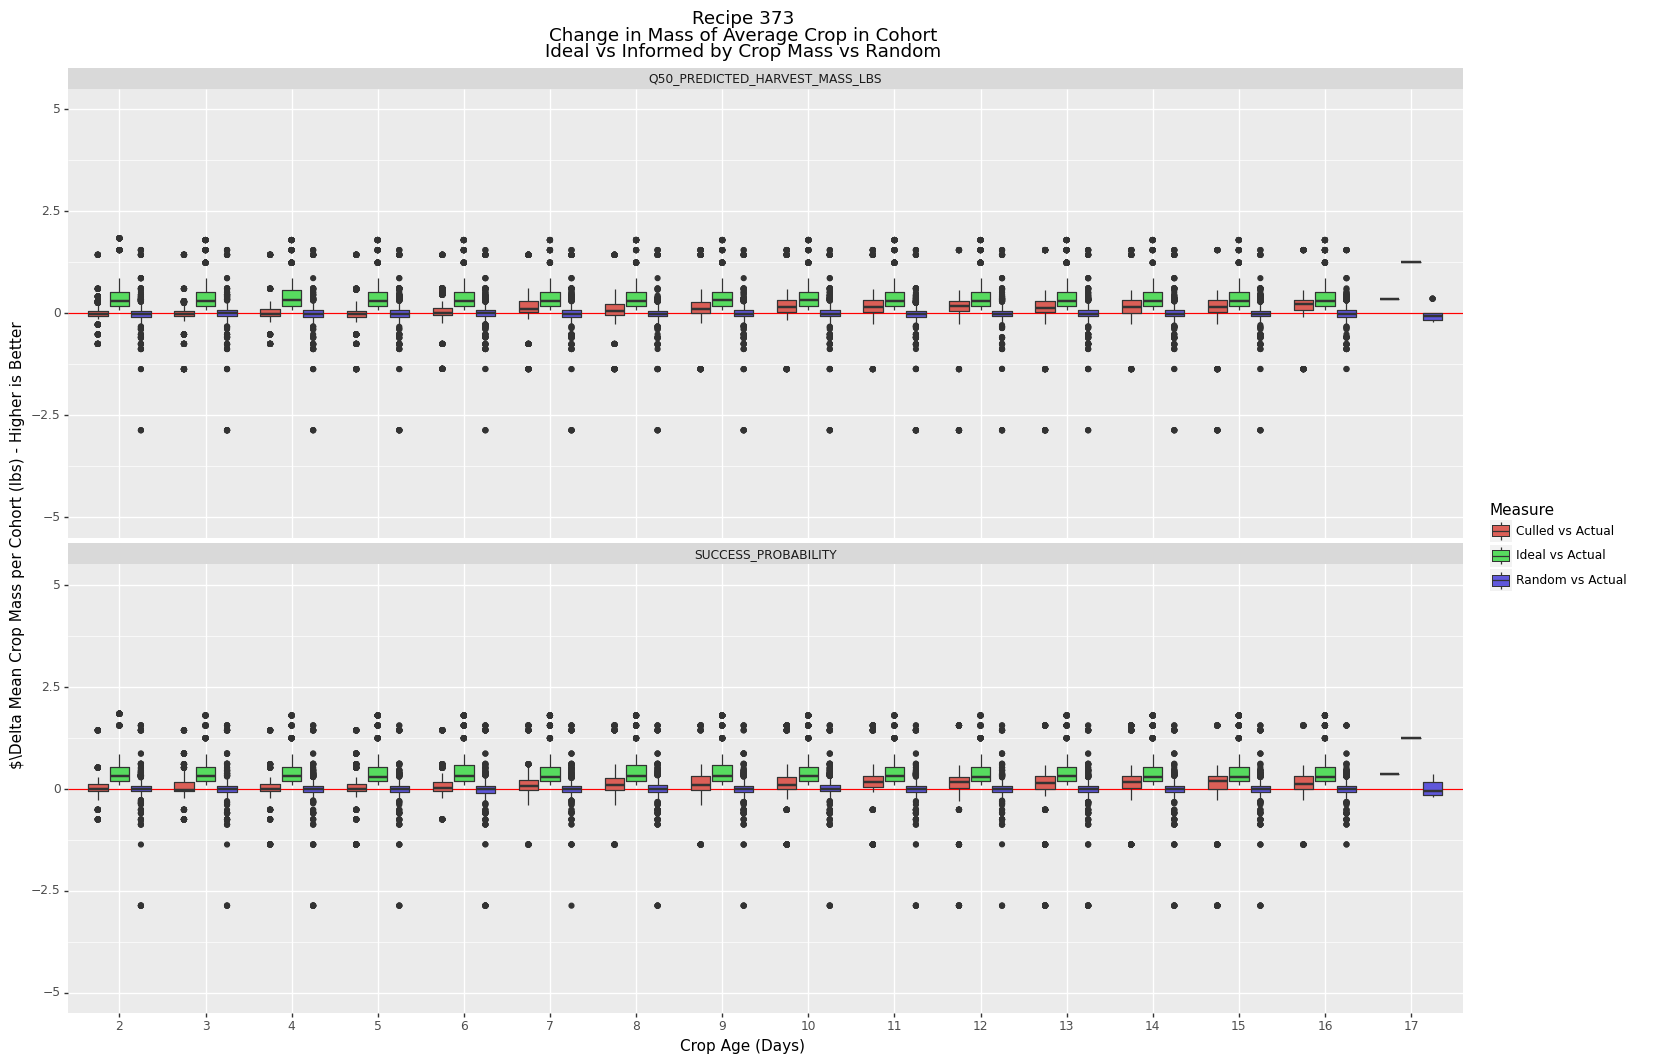


Recipe: 489


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 628 rows containing non-finite values.


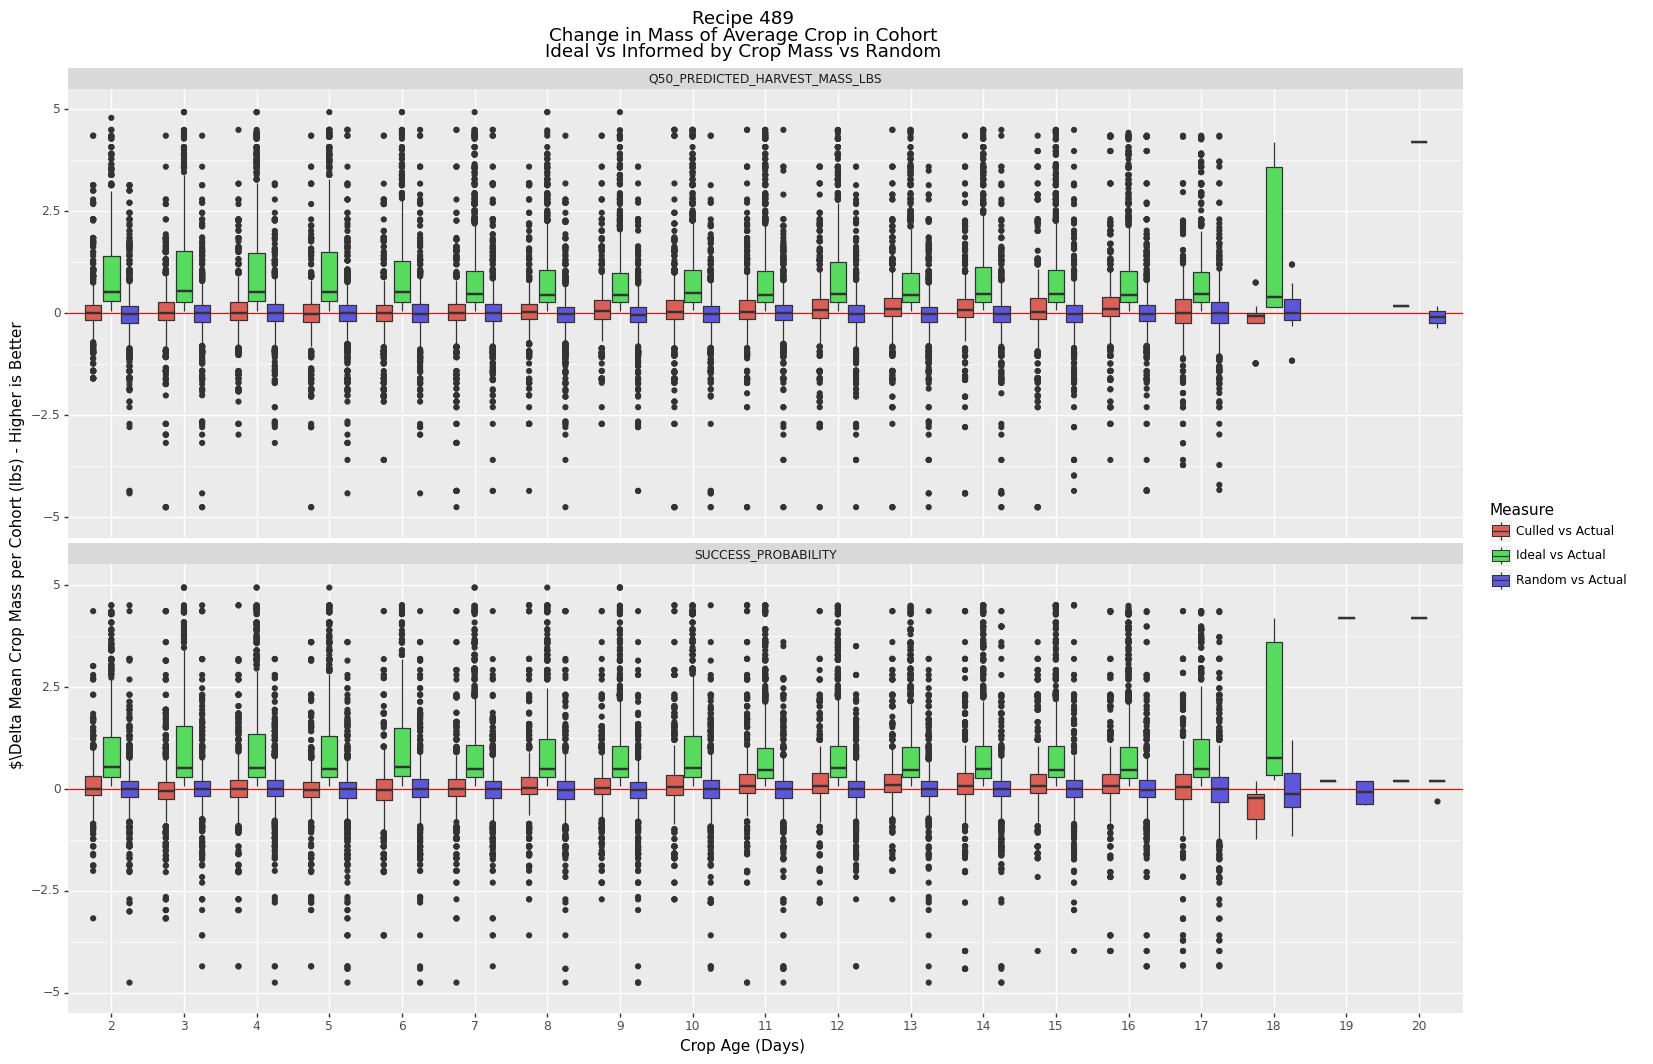


Recipe: 516


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 10397 rows containing non-finite values.


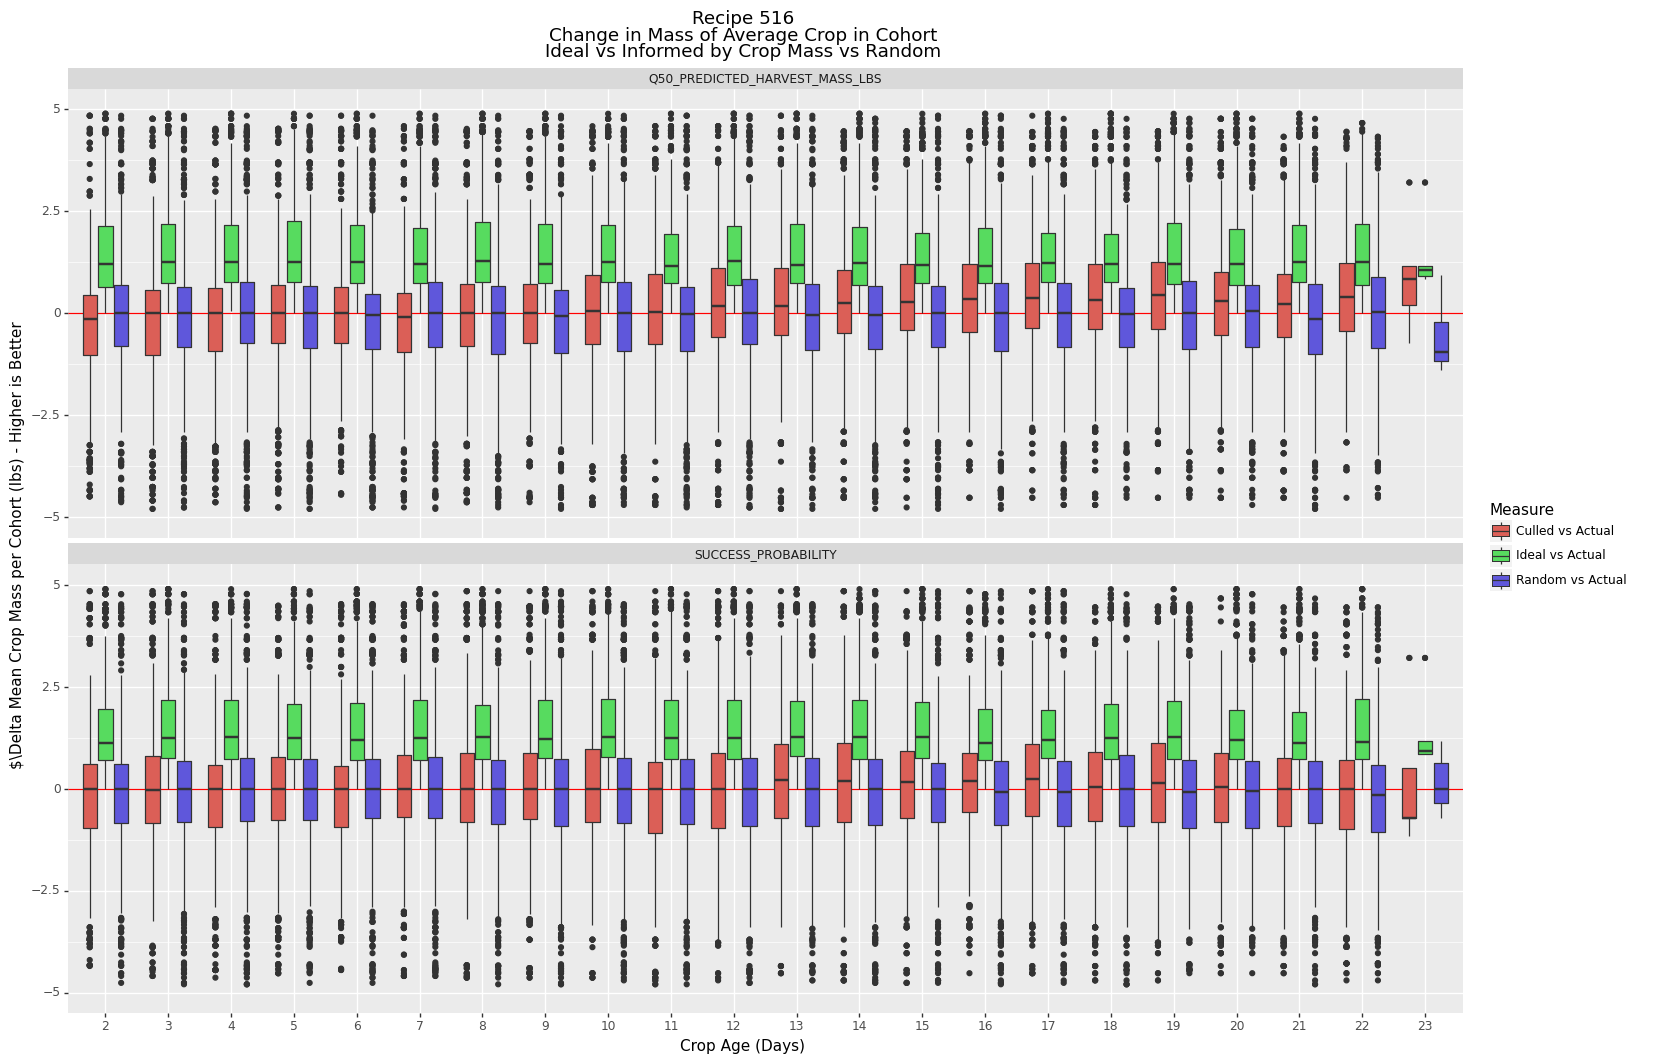


Recipe: 636


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 1046 rows containing non-finite values.


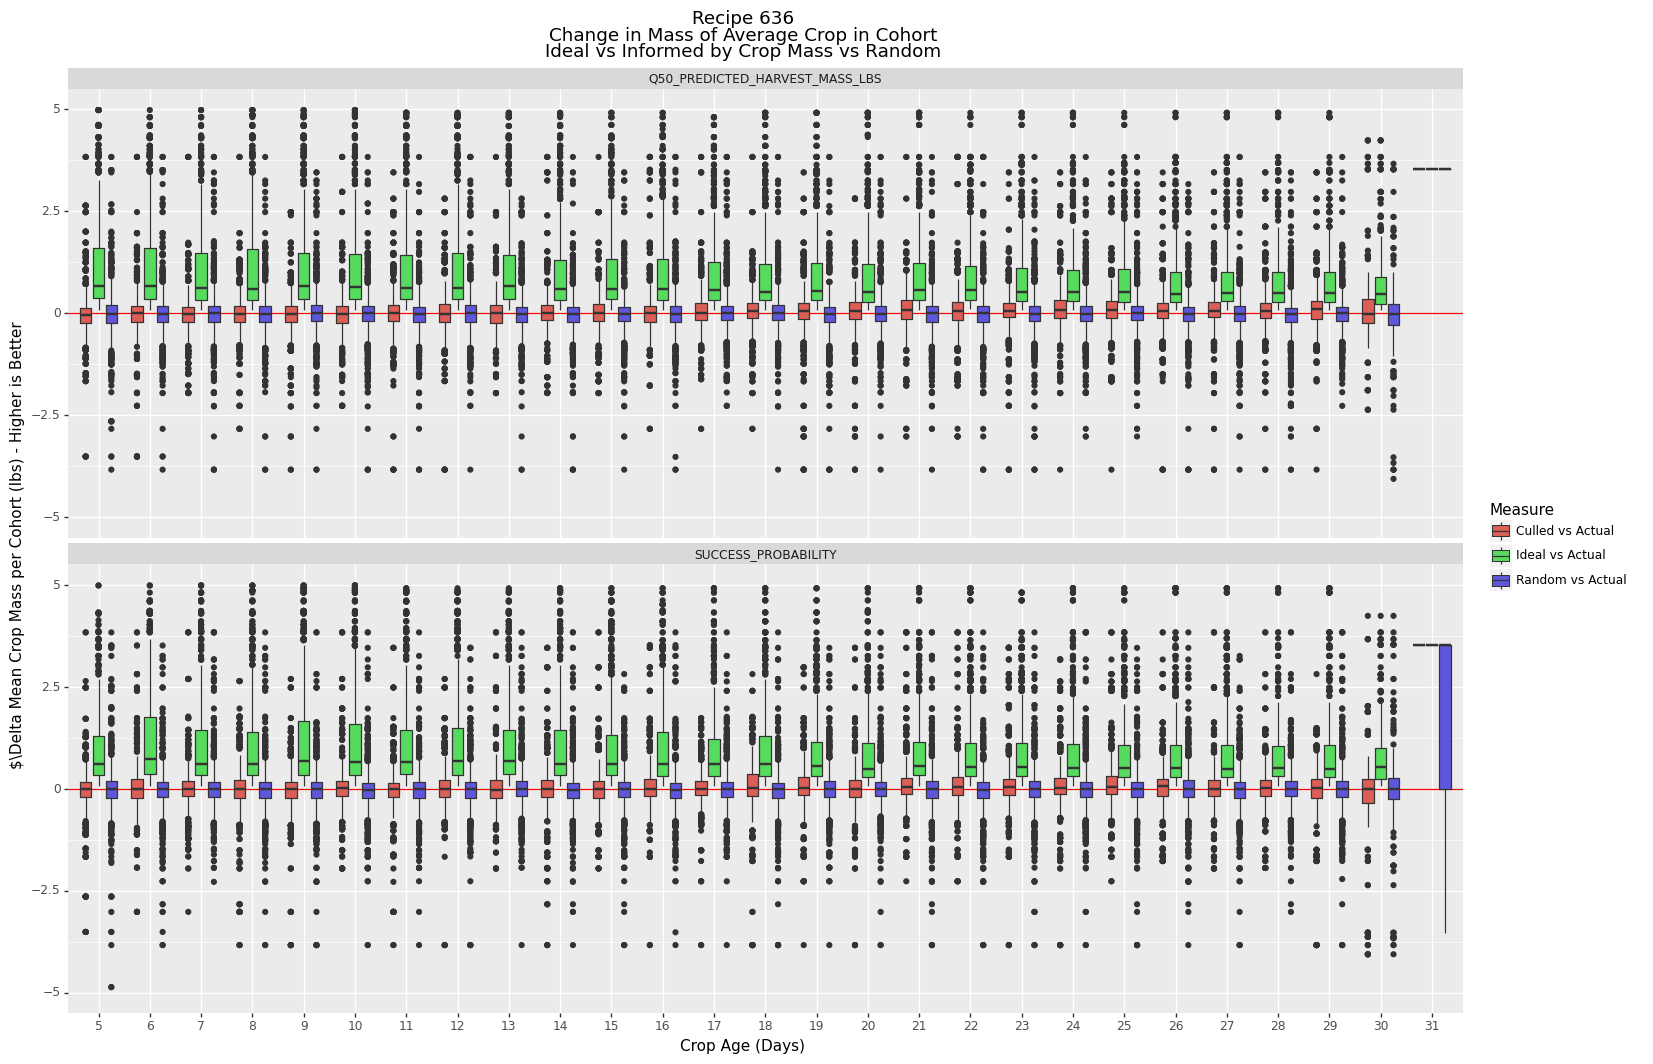


Recipe: 472


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 1828 rows containing non-finite values.


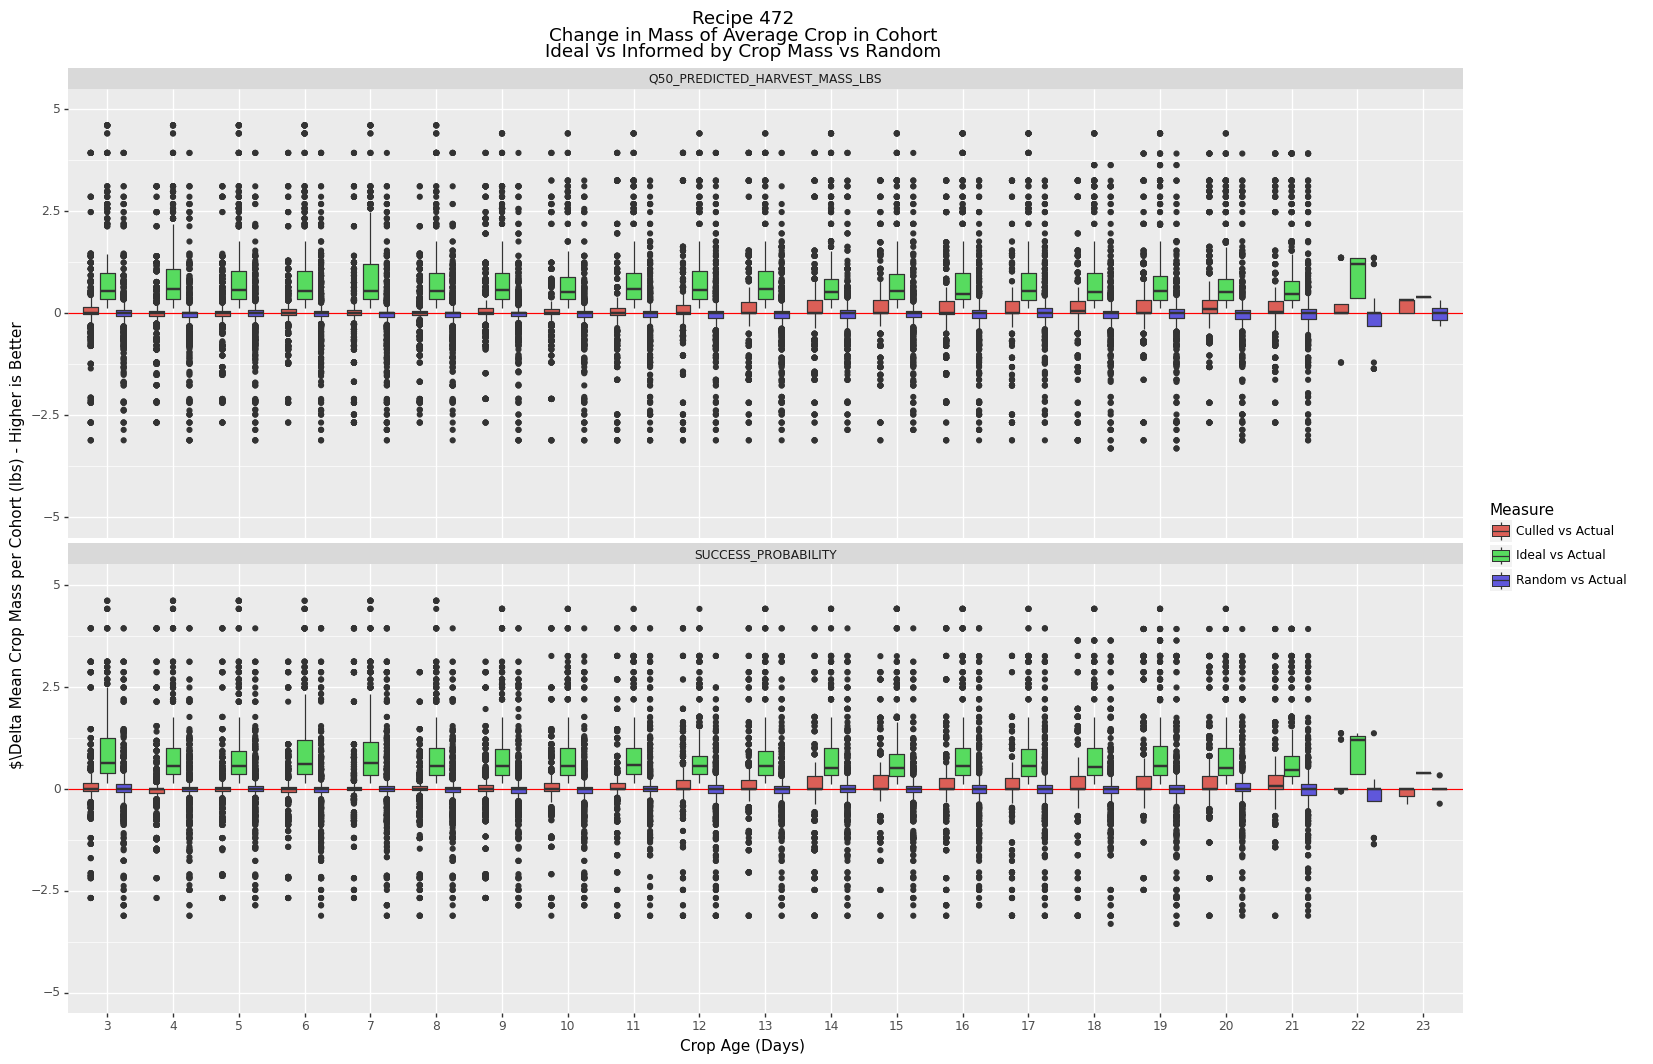


Recipe: 499


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 16178 rows containing non-finite values.


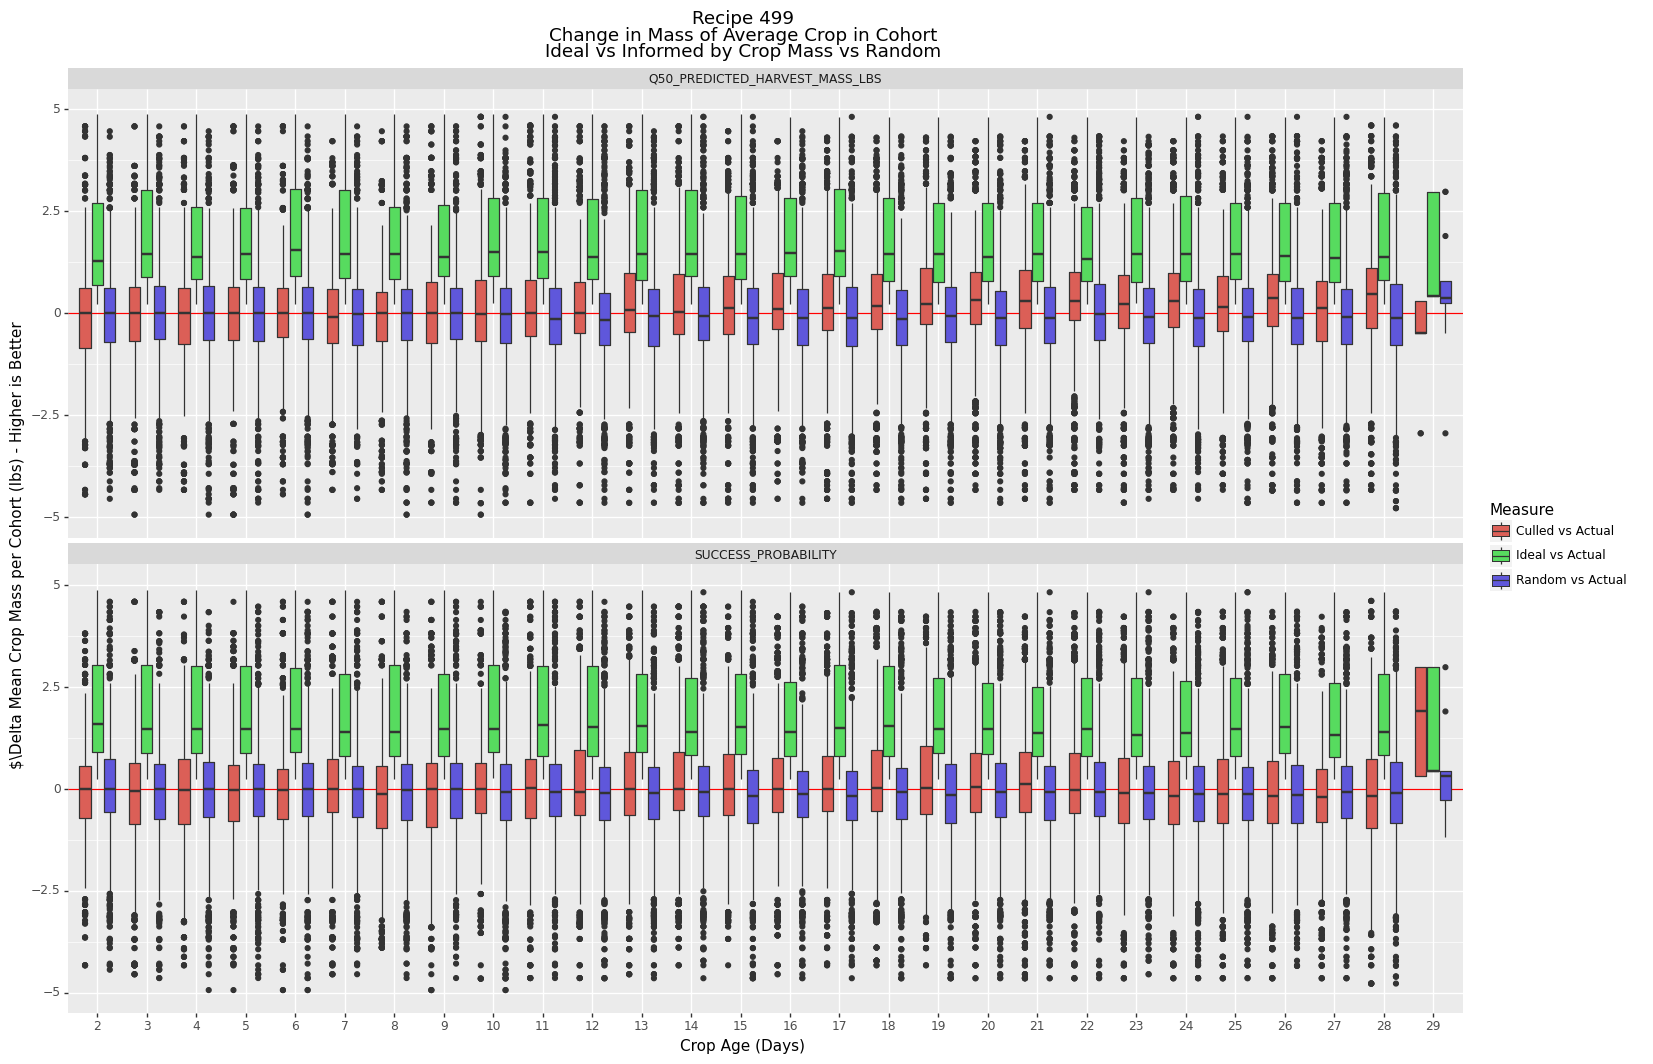


Recipe: 336


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 1177 rows containing non-finite values.


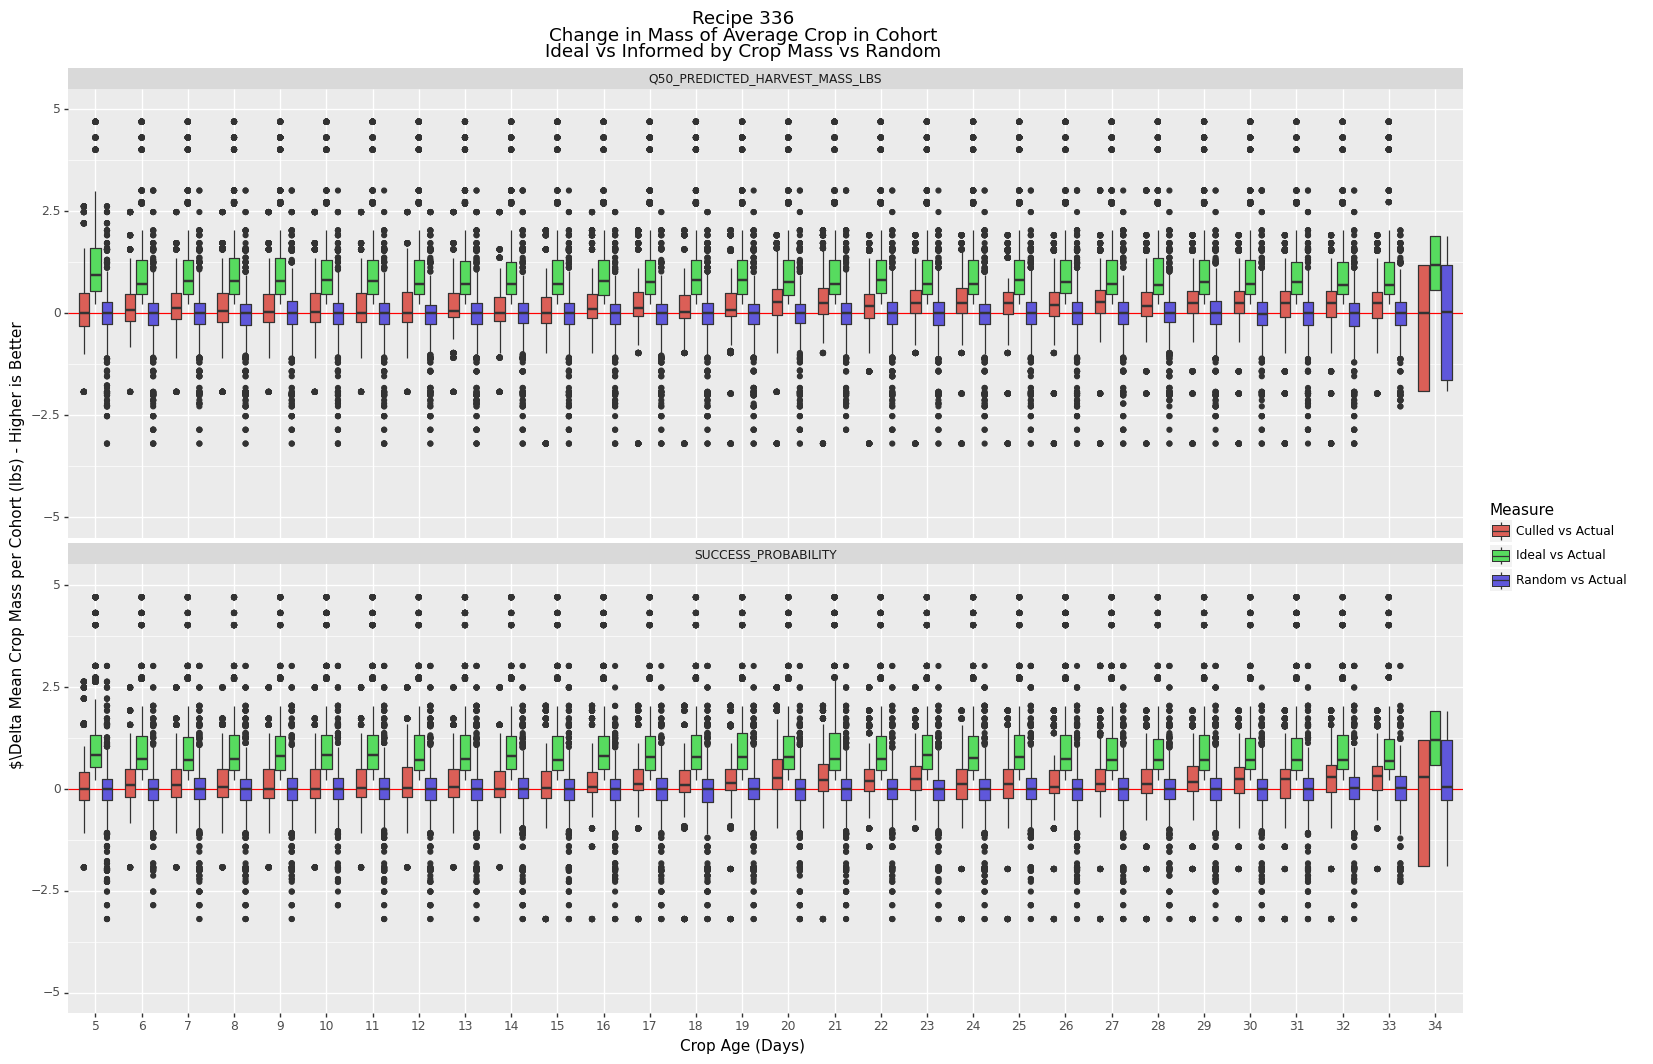


Recipe: 391


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 16185 rows containing non-finite values.


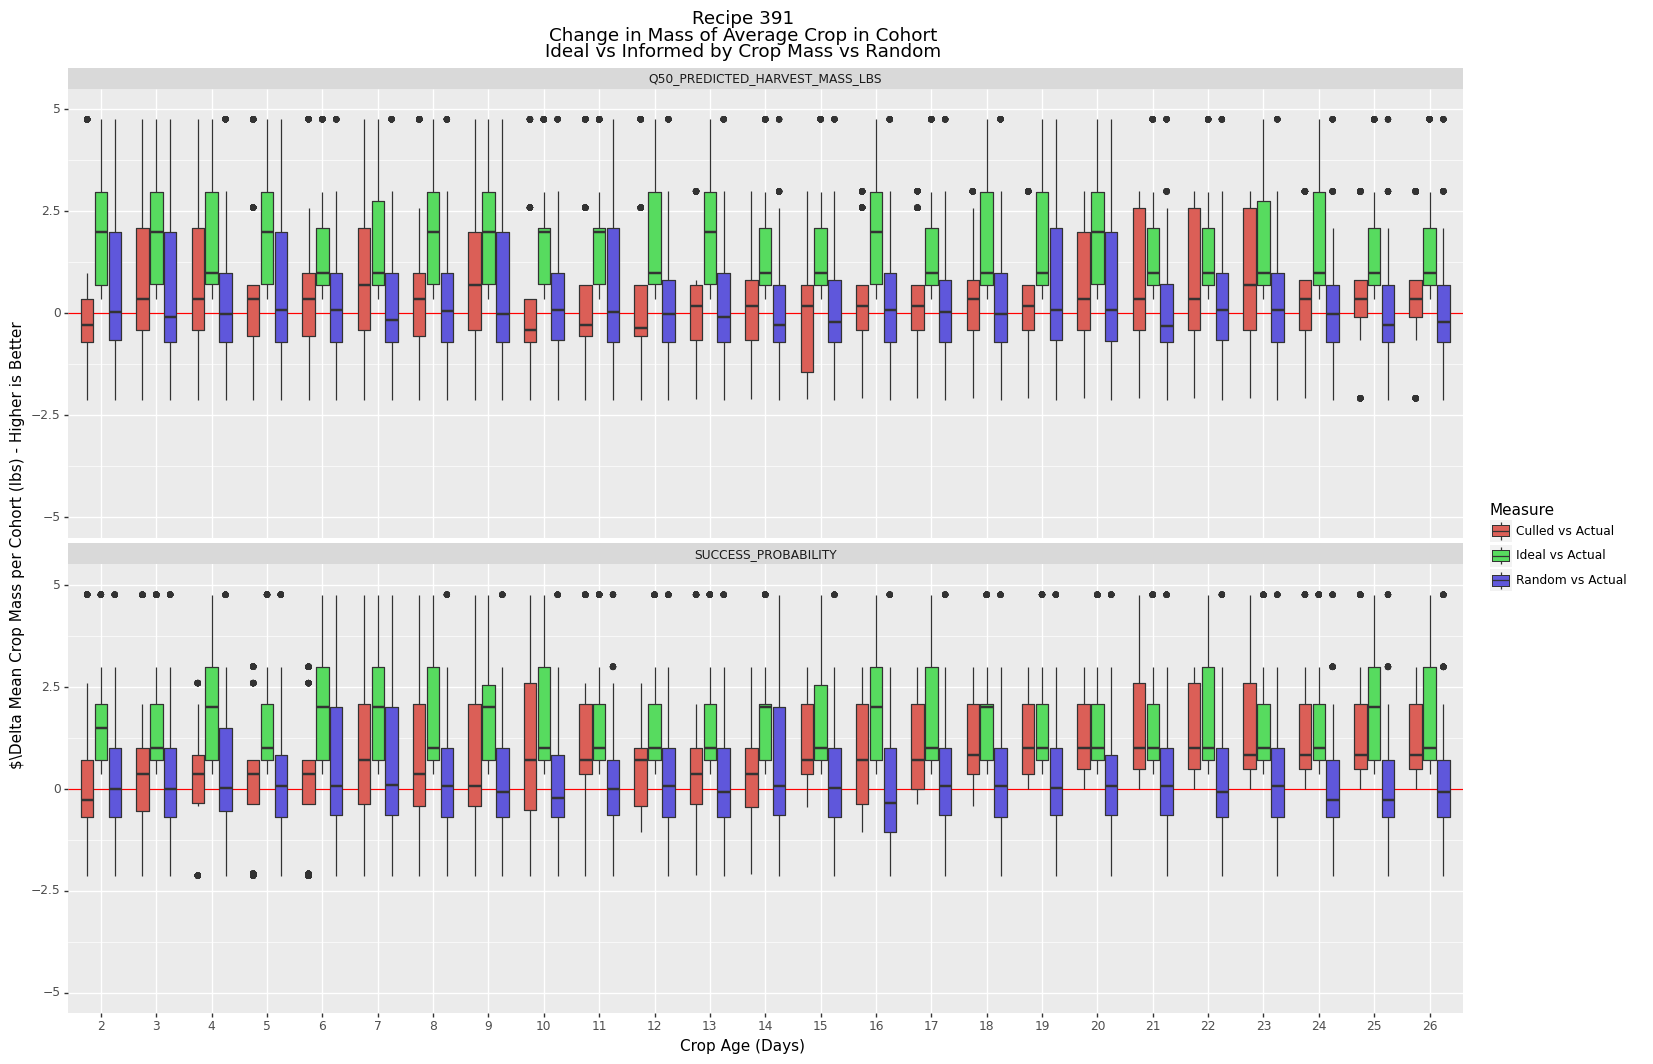


Recipe: 493


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 16887 rows containing non-finite values.


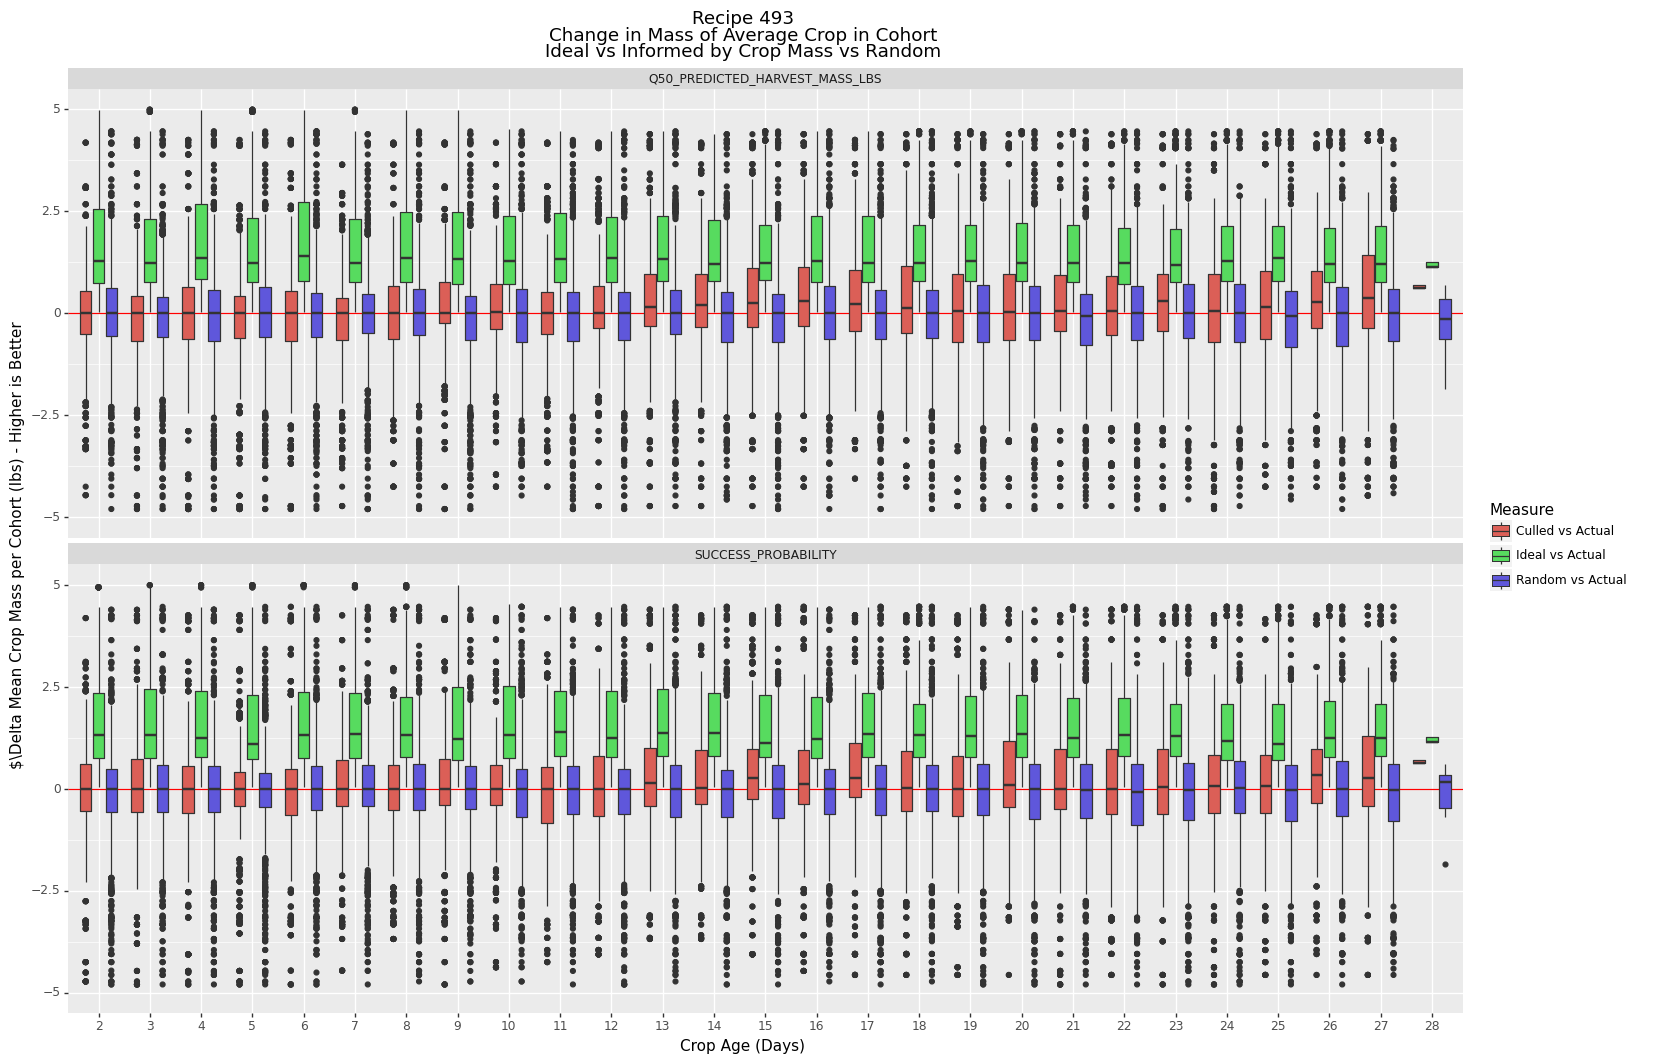

In [22]:
for recipe in recipe_dfs:
    print(f"Recipe: {recipe}")
    print(graphs(recipe_dfs[recipe],recipe))

## Conclusions <div id="conclusions"></div>

* The impact of removing the ideal crop is often modest, with a median near 1lb 
 * This indicates that the total salable mass not of the crop but *of the cohort* will can increase by at most this much with the removal of a single crop.
* Judging by Crop mass ('Q50_PREDICTED_HARVEST_MASS_LBS') does not generally show different patterns than judging by 1-failure probability ('SUCCESS_PROBABILITY')
* Culling a crop doesn't appear to frequently be different than random 
 * This suggests that crop mass isn't currently useful for ranking crops by final harvest mass while those crops are in flight.